In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import pickle as pkl
import seaborn as sns

from scipy import stats
from scipy.stats import cumfreq
import statsmodels.api as sm

from tabulate import tabulate
from scipy.stats import f

import os

In [27]:
os.chdir("/Users/avascharfstein/Desktop/Dartmouth/mds-final")

In [28]:
df = pd.read_csv('data/df_relabeled.csv')
with open('data/specific_stats.pkl', 'rb') as f:
    specific_stats = pkl.load(f)
with open('data/overall_stats.pkl', 'rb') as f:
    overall_stats = pkl.load(f)
with open('data/context_vars.pkl', 'rb') as f:
    context_vars = pkl.load(f)

stats_df = df.drop(columns = context_vars)

In [29]:
def dist_measures(dist):
    mean = np.mean(dist)
    median = np.median(dist)
    std = np.std(dist)
    if std==0:
        skew = 0
    else:
        skew = 3*(mean-median)/std
    return [mean, median, skew, std]

def plt_dist(df, var, xlabel= None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    [m_mean, m_median, m_skew, m_std] = dist_measures(m_dist)
    [w_mean, w_median, w_skew, w_std] = dist_measures(w_dist)
    metric = "Mean" # default metric is mean
    m_metric = m_mean
    w_metric = w_mean
    #Assume skewness is >0 since there will be no negative values (FOR NOW)
    if m_skew > .5 or w_skew >.5: # if one of the distributions is skewed heavily..
        metric = "Median"
        m_metric = m_median
        w_metric = w_median

    if xlabel is None:
        xlabel = var.replace("_"," ").title()

    sns.histplot(m_dist, alpha=0.6, label='Mens', color='skyblue')  # Replace 'blue' with 'skyblue'
    sns.histplot(w_dist, alpha=0.4, label='Womens', color='orange')  # Replace 'orange' with 'salmon'

    plt.axvline(m_metric, color='skyblue', linestyle='dashed', linewidth=3)
    plt.axvline(w_metric, color='orange', linestyle='dashed', linewidth=3)
    #plt.title("Dashed Line represents " + metric, fontsize=7)
    plt.suptitle("Histogram of " + var.replace("_", " ").title())
    plt.text(0.5, -0.15, f"Dashed Line represents {metric}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    plt.xlabel(xlabel)
    plt.ylabel("Matches")
    plt.legend(loc='upper right')
    plt.show()

    # plt.hist(m_dist, alpha=0.4, label='Mens', color = 'blue') #0d98ba
    # plt.hist(w_dist, alpha=0.4, label='Womens', color = 'orange') #7804b3
    
    # plt.axvline(m_metric, color = 'blue', linestyle='dashed', linewidth=2)
    # plt.axvline(w_metric, color='orange', linestyle='dashed', linewidth=2)
    # plt.title("Dashed Line represents "+metric, fontsize = 7)
    # plt.suptitle("Histogram of " +var.replace("_"," ").title())
    # plt.xlabel(xlabel)
    # plt.ylabel("Matches")
    # plt.legend(loc='upper right')
    # plt.show()

In [30]:
h = "_home"
a = "_away"

In [31]:
specific_stats.remove('rs')
specific_stats.remove('seed')
specific_stats.remove('win')

In [32]:
specific_stats

{'aces',
 'breakpoints_won',
 'double_faults',
 'errors',
 'first_serve_points_won',
 'first_serve_successful',
 'games_won',
 'max_games_in_a_row',
 'max_points_in_a_row',
 'points_won',
 'points_won_from_last_10',
 'second_serve_points_won',
 'second_serve_successful',
 'service_games_won',
 'service_points_lost',
 'service_points_won',
 'tiebreaks_won',
 'total_breakpoints',
 'unforced_errors',
 'winners'}

In [33]:
features_diff = []
for stat in specific_stats:
    stats_df[stat+"_diff"] = stats_df[stat+h]-stats_df[stat+a] # abs() commented out
    features_diff.append(stat+"_diff")

features_diff.append("avg_set_diff")

for x in [x for x in overall_stats if x not in ['match_length','sets','men']]:
    features_diff.append(x)


In [34]:
# Remove features whose mean and variance < 1
to_remove = []
for feature in specific_stats:
    ms = dist_measures(stats_df[feature+"_diff"])
    ms_h = dist_measures(stats_df[feature+h])
    ms_a = dist_measures(stats_df[feature+a])
    if ms_h[0] < 1 and ms_h[0] < 1 and ms_h[3] < 1 and ms_a[3] <1:
        # print(feature)
        # print(ms_h)
        # print(ms_a)
        # plt_dist(stats, feature+h)
        to_remove.append(feature+"_diff")
        print("Removed "+feature+"_diff")

features_diff = list(set(features_diff) - set(to_remove))

Removed tiebreaks_won_diff


In [35]:
features_diff_df = stats_df[features_diff]

In [36]:
features_diff_df

double_faults_diff  avg_game_length  service_points_won_diff  \
0             -1.000000         4.433333                 1.500000   
1              0.500000         5.549359                -6.000000   
2              0.000000         5.354386                 0.500000   
3              0.666667         5.134896                 0.333333   
4             -0.666667         4.678333                 3.666667   
..                  ...              ...                      ...   
940            1.333333         5.782184                 1.666667   
941           -0.333333         5.559259                 7.000000   
942           -0.666667         5.368333                 3.333333   
943           -2.500000         5.235526                -2.000000   
944            0.000000         6.362366                 4.000000   

     second_serve_points_won_diff  service_games_won_diff  points_won_diff  \
0                       -1.000000                0.500000         5.500000   
1                       -2.500000                0.000000        -3.000000   
2                        1.000000                1.000000         8.500000   
3                        2.666667                0.000000        -2.000000   
4                        3.333333                1.333333         6.000000   
..                            ...                     ...              ...   
940                      0.666667                1.000000         2.666667   
941                      5.666667                1.666667         7.333333   
942                     -1.000000                1.333333         7.666667   
943                     -0.500000               -0.750000        -5.000000   
944                      4.000000                1.333333         7.000000   

     max_points_in_a_row_diff  breakpoints_won_diff  \
0                           0              0.500000   
1                          -1              0.000000   
2                           2              1.500000   
3                          -3             -0.333333   
4                           1              1.000000   
..                        ...                   ...   
940                        -4              1.333333   
941                         3              1.333333   
942                         4              1.000000   
943                        -3             -0.500000   
944                         4              0.666667   

     first_serve_points_won_diff  avg_set_length  ...  avg_set_diff  \
0                       2.500000       50.983333  ...      1.500000   
1                      -3.500000       72.141667  ...      1.000000   
2                      -0.500000       50.866667  ...      2.500000   
3                      -2.333333       54.772222  ...      0.666667   
4                       0.333333       46.783333  ...      2.000000   
..                           ...             ...  ...           ...   
940                     1.000000       55.894444  ...      2.333333   
941                     1.333333       50.033333  ...      3.000000   
942                     4.000000       53.683333  ...     -2.666667   
943                    -0.750000       49.737500  ...     -1.500000   
944                    -0.333333       65.744444  ...     -2.333333   

     second_serve_successful_diff  games_won_diff  aces_diff  \
0                       -2.500000        1.500000   5.500000   
1                        0.000000       -1.000000  -0.500000   
2                       -2.500000        2.500000   1.500000   
3                        2.333333       -0.666667  -1.333333   
4                        2.000000        2.000000   0.333333   
..                            ...             ...        ...   
940                      0.666667        2.333333   1.333333   
941                      6.000000        3.000000  -1.000000   
942                      1.333333        2.666667   0.000000   
943                      3.000000       -1.500000  -2.250000   
944                  

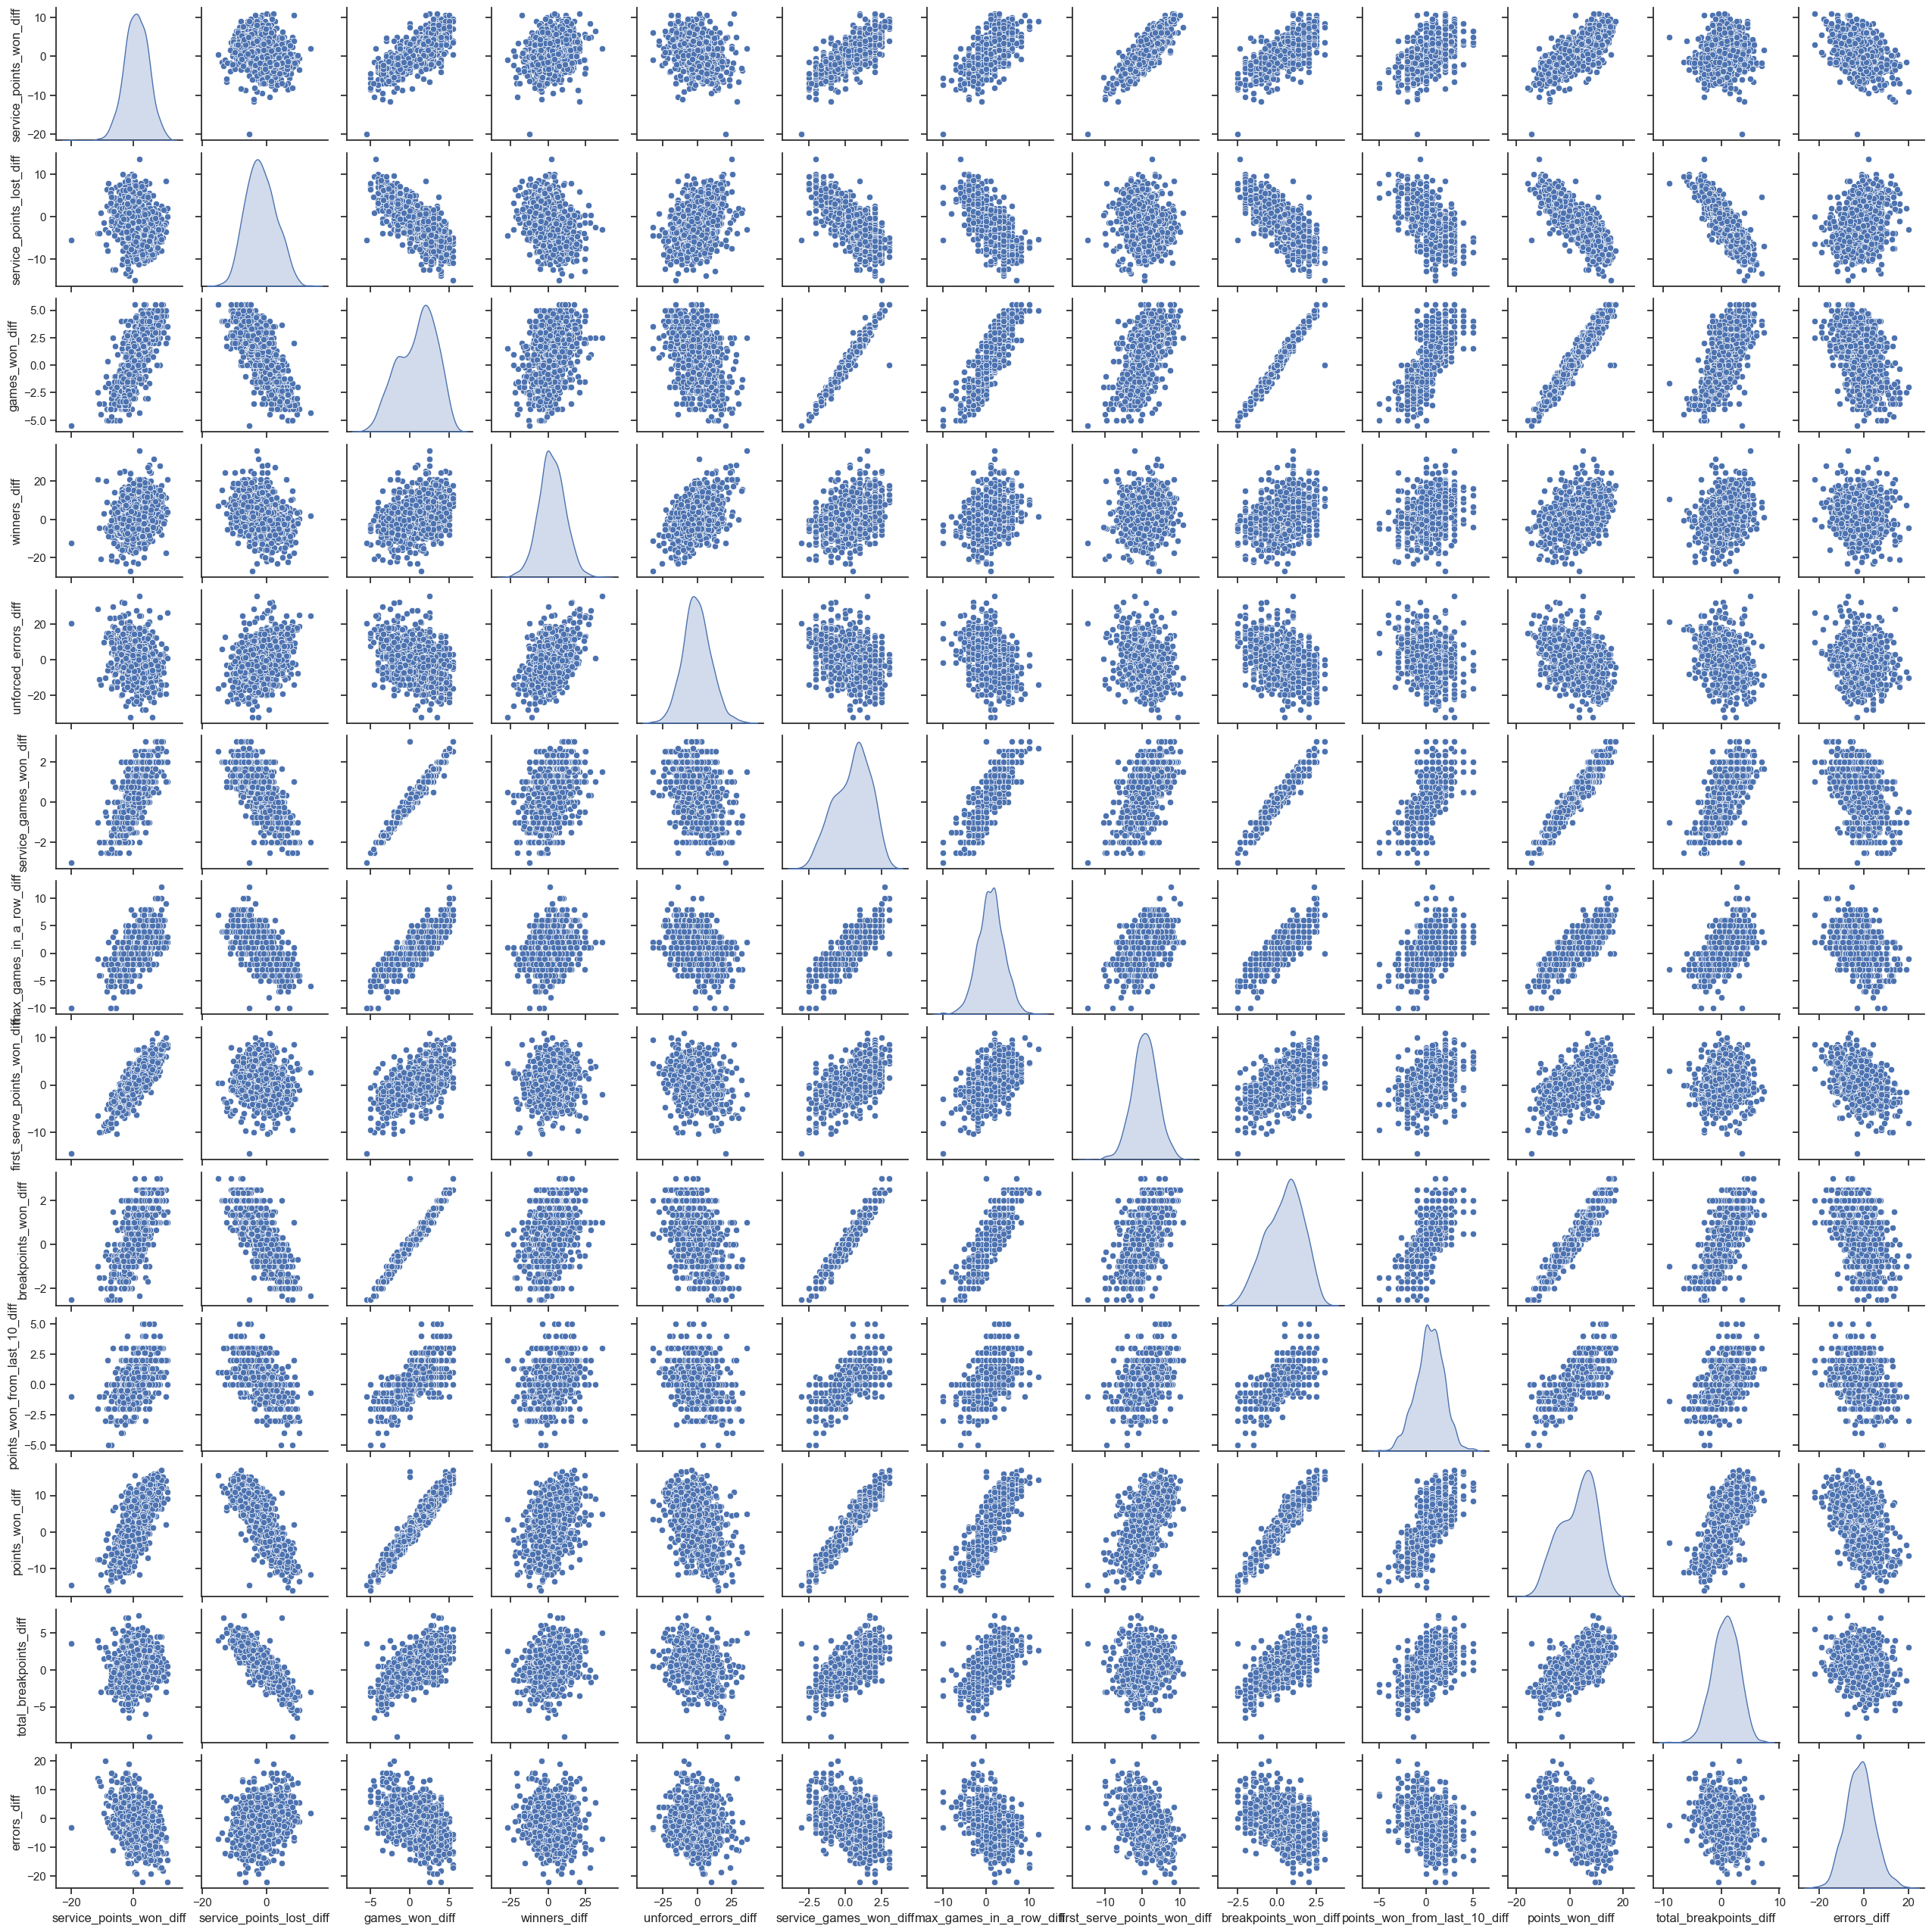

In [38]:
#features_diff_df.columns

# to_try = ['aces_diff','double_faults_diff','points_won_diff','avg_points_per_game','avg_game_length','groundstroke_errors_diff','service_games_won_diff','breakpoints_won_diff','backhand_winners_diff','forehand_winners_diff']
to_try = ['service_points_won_diff',
'service_points_lost_diff',
'games_won_diff',
'winners_diff',
'unforced_errors_diff',
'service_games_won_diff',
'max_games_in_a_row_diff',
'first_serve_points_won_diff',
'breakpoints_won_diff',
'points_won_from_last_10_diff',
'points_won_diff',
'total_breakpoints_diff',
'errors_diff']

sns.set(style="ticks")
sns.pairplot(features_diff_df[to_try], height=2, markers='o', diag_kind='kde')

# Show the plots
plt.show()


In [ ]:
# for feature in features_diff:
#     plt_dist(stats_df, feature)

In [39]:
def plt_ecdf(df, var, xlabel=None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]

    ks = stats.kstest(m_dist, w_dist)

    m_x, m_cf = np.sort(m_dist), np.arange(1, len(m_dist) + 1) / len(m_dist)
    w_x, w_cf = np.sort(w_dist), np.arange(1, len(w_dist) + 1) / len(w_dist)

    if xlabel is None:
        xlabel = var.replace("_", " ").title()

    plt.step(x=m_x, y=m_cf, label='Mens', color='skyblue')
    plt.step(x=w_x, y=w_cf, label='Womens', color='orange')

    plt.title("Empirical CDF of " + var.replace("_", " ").title())
    plt.xlabel(xlabel)
    plt.ylabel("Cumulative Probability")
    plt.legend(loc='lower right')
    # Display KS test statistic and p-value
    plt.text(0.5, -0.15, f"KS Statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    
    plt.show()


In [61]:
def summarize(df, var):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    m_results = stats.describe(m_dist)
    w_results = stats.describe(w_dist)
    
    summary_data = [
        ["Mean", m_results.mean, w_results.mean],
        ["Median", np.median(m_dist), np.median(w_dist)],
        ["Variance", m_results.variance, w_results.variance],
        ["Skewness", m_results.skewness, w_results.skewness],
        ["Kurtosis", m_results.kurtosis, w_results.kurtosis],
    ]

    significant = []

    # KS-Test for distributions
    ks_stat, ks_p_value = stats.kstest(m_dist, w_dist)
    if ks_p_value <.05:
        significant.append("KS-Test")

    # T-test for means
    t_stat, t_p_value = stats.ttest_ind(m_dist, w_dist)
    if t_p_value < .05:
        significant.append("T-test")

    # Mann-Whitney U test (non-parametric test for comparing distributions)
    u_stat, mw_p_value = stats.mannwhitneyu(m_dist, w_dist)
    if mw_p_value < .05:
        significant.append("Mann-Whitney U")

    # F-test for variances
    f_stat, f_p_value = stats.levene(m_dist, w_dist)
    if f_p_value < .05:
        significant.append("Levene")

    
    if m_results.skewness >= .5 or m_results.skewness <= -.5:
        significant.append("M-Skew")
    if w_results.skewness >= .5 or w_results.skewness <= -.5:
        significant.append("W-Skew")

    # Results table
    results_table = [
        ["KS-test (Distribution)", ks_stat, ks_p_value],
        ["T-test (Means)", t_stat, t_p_value],
        ["Mann-Whitney U", u_stat, mw_p_value],
        ["Levene-test (Variances)", f_stat, f_p_value],
    ]
    
    var_format = var.replace("_"," ")
    # Print the tables
    print(f"Summary Statistics for {var_format.title()}:")
    print(tabulate(summary_data, headers=["Statistic", "Men", "Women"], tablefmt="grid"))
    print(tabulate(results_table, headers=["Test", "Statistic", "P-value"], tablefmt="grid"))
    print("Tests that are statistically significant:"+str(significant))
    print('\n\n')

def plt_qq(df, var, name):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    stats.probplot(m_dist, plot=axes[0])
    axes[0].set_title('Mens')
    axes[0].get_lines()[0].set_markeredgecolor('none')
    axes[0].get_lines()[0].set_markerfacecolor('skyblue')  # Set color for Men's QQ plot
    axes[0].get_lines()[1].set_color('black')  # Set color for the line


    stats.probplot(w_dist, plot=axes[1])
    axes[1].set_title('Womens')
    axes[1].get_lines()[0].set_markeredgecolor('none')
    axes[1].get_lines()[0].set_markerfacecolor('orange')  # Set color for Women's QQ plot
    axes[1].get_lines()[1].set_color('black')


    fig.suptitle(name)
    plt.show();

In [60]:
sorted(features_diff)

['aces_diff',
 'avg_game_length',
 'avg_points_per_game',
 'avg_set_diff',
 'avg_set_games',
 'avg_set_length',
 'breakpoints_won_diff',
 'double_faults_diff',
 'errors_diff',
 'first_serve_points_won_diff',
 'first_serve_successful_diff',
 'games_won_diff',
 'max_games_in_a_row_diff',
 'max_points_in_a_row_diff',
 'points_won_diff',
 'points_won_from_last_10_diff',
 'second_serve_points_won_diff',
 'second_serve_successful_diff',
 'service_games_won_diff',
 'service_points_lost_diff',
 'service_points_won_diff',
 'total_breakpoints_diff',
 'unforced_errors_diff',
 'winners_diff']

Summary Statistics for Aces Diff:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        |  0.314079 |  0.376263  |
+-------------+-----------+------------+
| Median      |  0.25     |  0         |
+-------------+-----------+------------+
| Variance    |  4.04056  |  1.90084   |
+-------------+-----------+------------+
| Skewness    | -0.107005 | -0.0375009 |
+-------------+-----------+------------+
| Kurtosis    |  0.924199 |  1.82543   |
+-------------+-----------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.12253  | 0.00148     |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -0.552196 | 0.580945    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          |

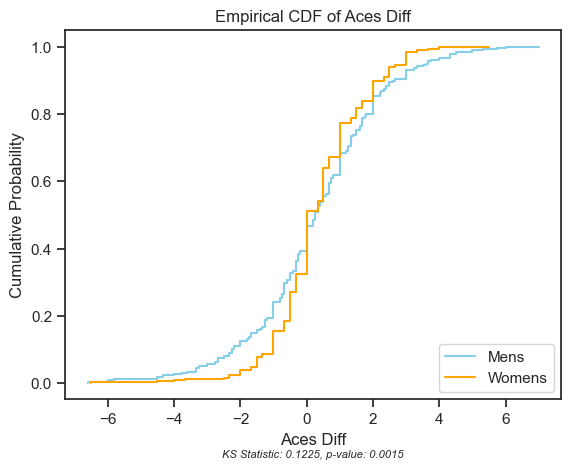

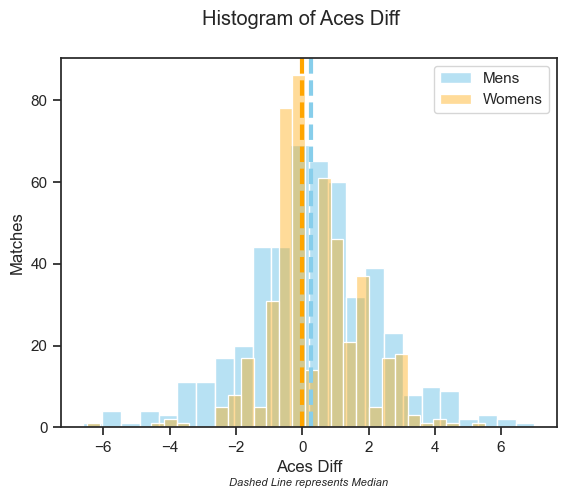

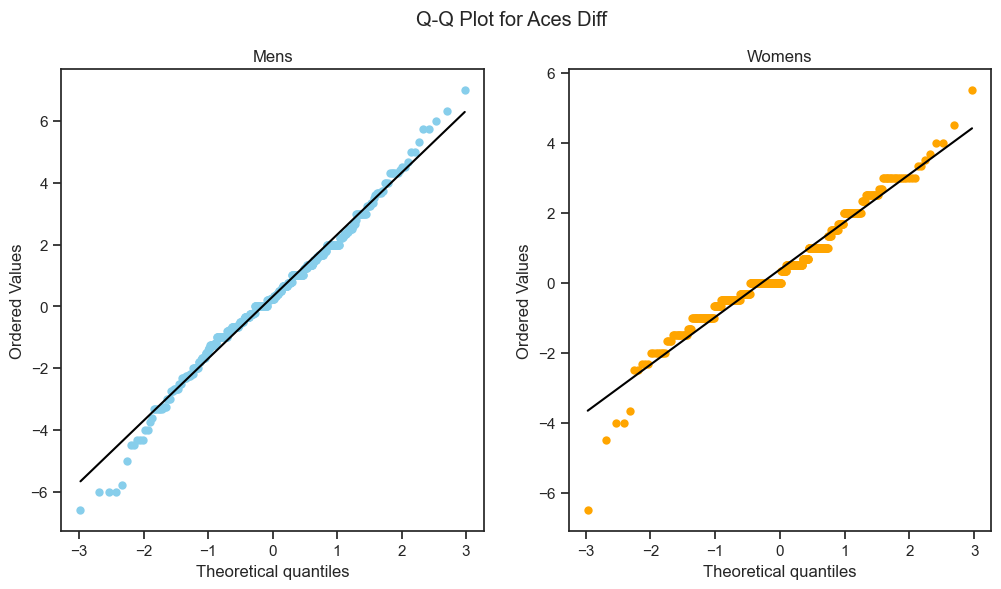

Summary Statistics for Avg Game Length:
+-------------+------------+----------+
| Statistic   |        Men |    Women |
+=============+============+==========+
| Mean        |  4.6178    | 4.74881  |
+-------------+------------+----------+
| Median      |  4.59808   | 4.7244   |
+-------------+------------+----------+
| Variance    |  0.328538  | 0.414392 |
+-------------+------------+----------+
| Skewness    |  0.257596  | 0.42051  |
+-------------+------------+----------+
| Kurtosis    | -0.0342572 | 0.383443 |
+-------------+------------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.105778 | 0.00919852  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -3.30729  | 0.000977622 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 98829        

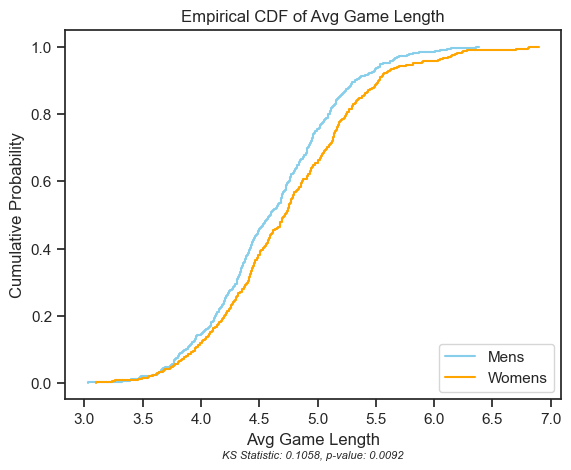

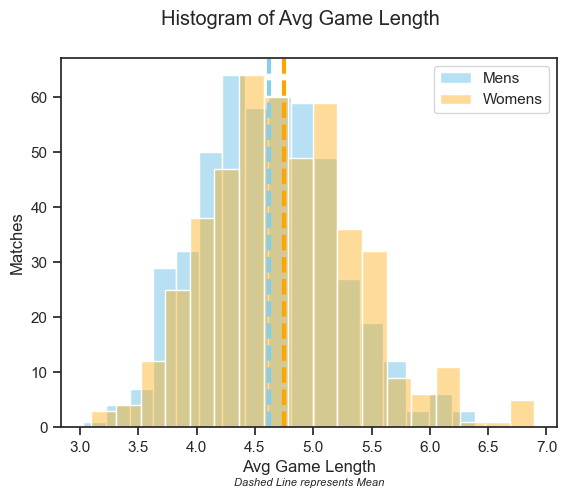

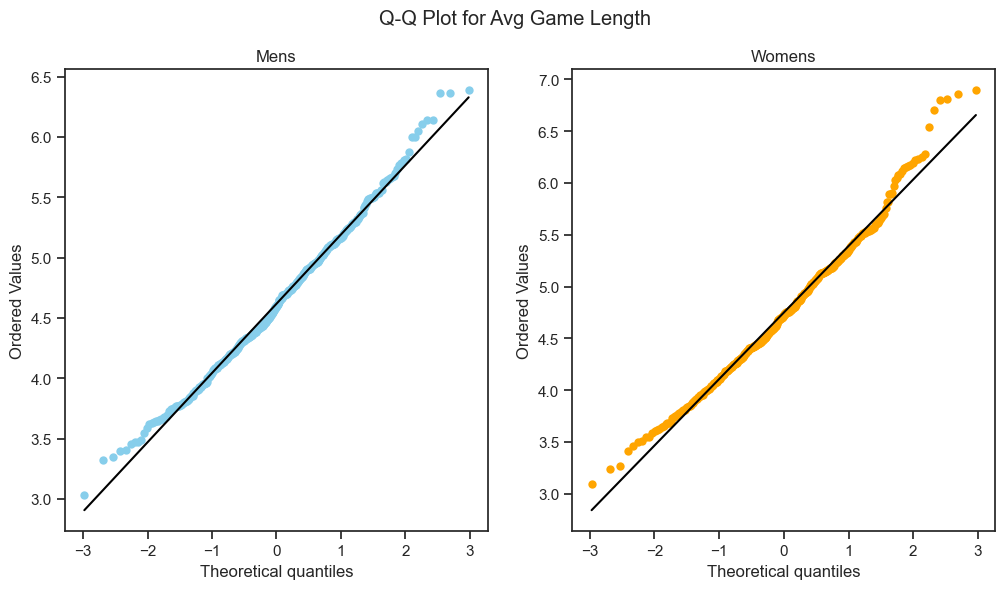

Summary Statistics for Avg Points Per Game:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 6.31197  | 6.55563  |
+-------------+----------+----------+
| Median      | 6.2619   | 6.52661  |
+-------------+----------+----------+
| Variance    | 0.222113 | 0.367988 |
+-------------+----------+----------+
| Skewness    | 0.70404  | 0.333225 |
+-------------+----------+----------+
| Kurtosis    | 1.17176  | 0.387261 |
+-------------+----------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.230284 | 1.77399e-11 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -6.91228  | 8.77739e-12 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 82233.5      | 2.64842e-12 |
+-----

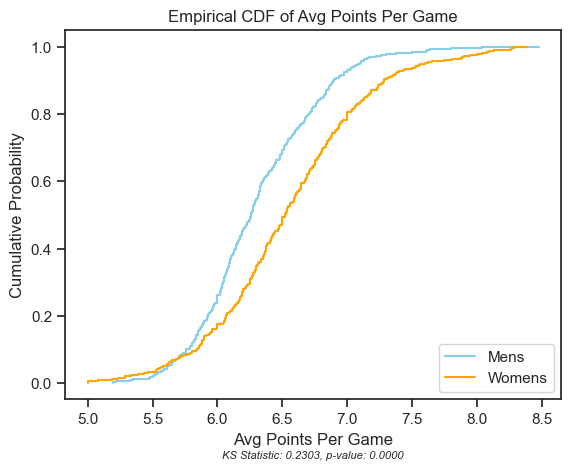

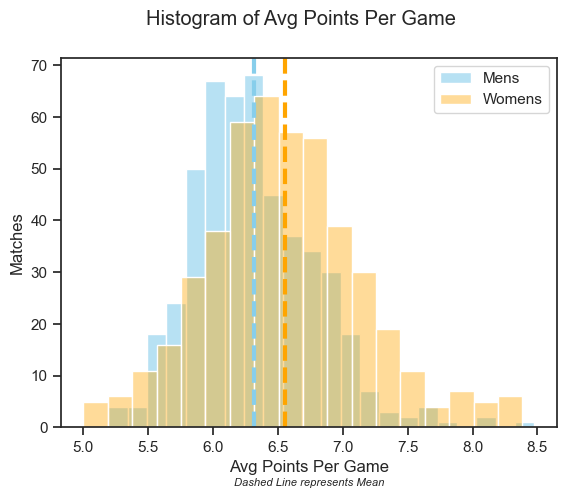

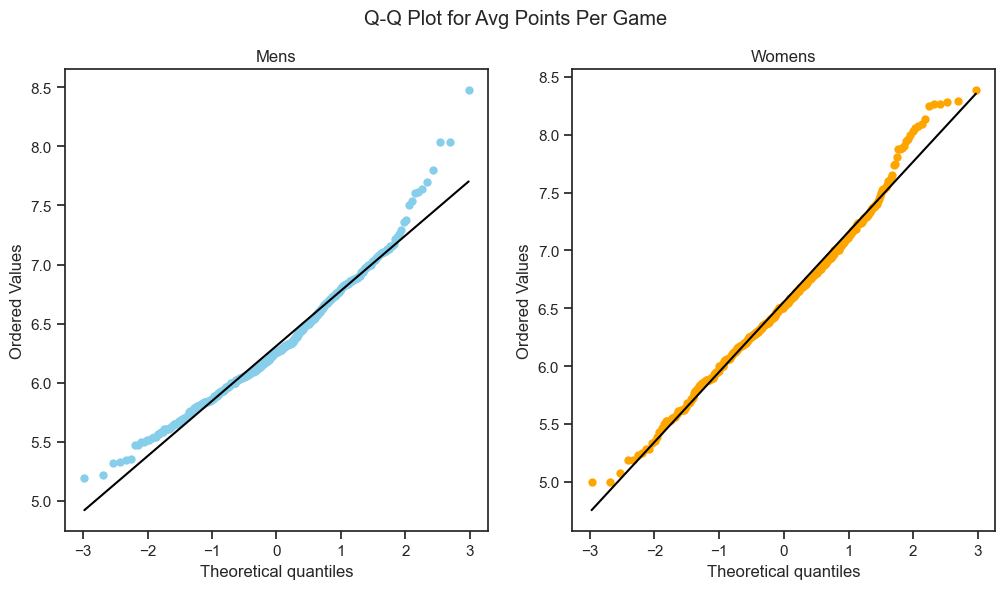

Summary Statistics for Avg Set Diff:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        |  0.0198413 | -0.0753968 |
+-------------+------------+------------+
| Median      |  0         |  0         |
+-------------+------------+------------+
| Variance    |  5.00272   |  8.3524    |
+-------------+------------+------------+
| Skewness    | -0.023032  |  0.0779285 |
+-------------+------------+------------+
| Kurtosis    | -0.935462  | -1.13928   |
+-------------+------------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.14728  | 6.08217e-05 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      0.567933 | 0.570216    |
+-------------------------+---------------+-------------+
| Mann-Whit

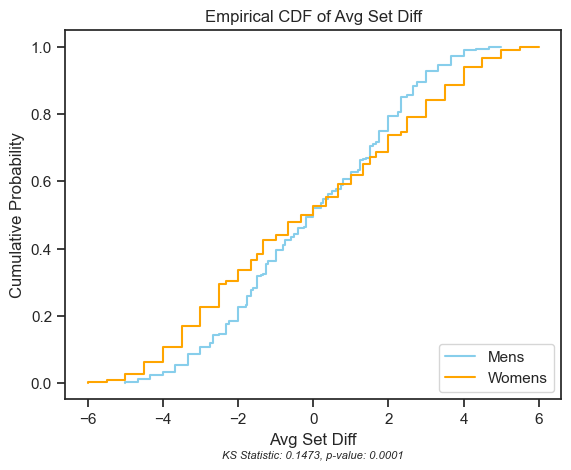

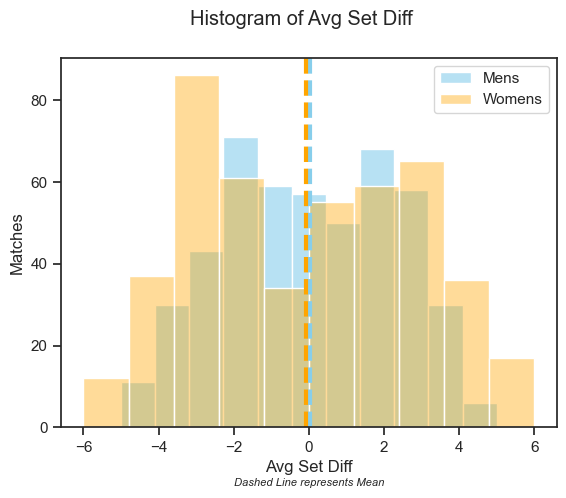

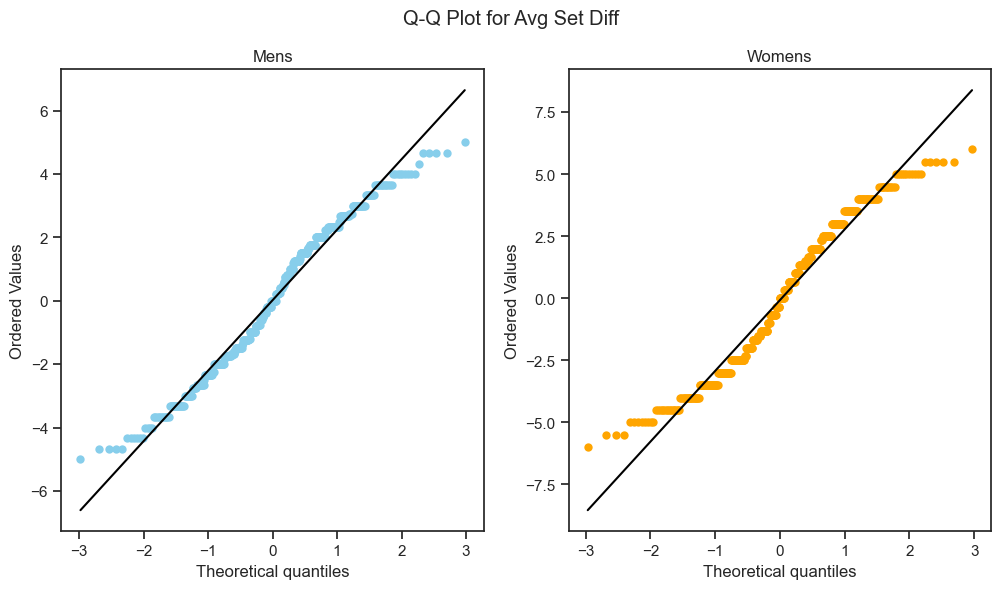

Summary Statistics for Avg Set Games:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  9.70914   |  9.15476  |
+-------------+------------+-----------+
| Median      |  9.75      |  9        |
+-------------+------------+-----------+
| Variance    |  1.17076   |  1.76263  |
+-------------+------------+-----------+
| Skewness    |  0.0133711 |  0.31314  |
+-------------+------------+-----------+
| Kurtosis    | -0.215308  | -0.128478 |
+-------------+------------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.248635 | 2.54311e-13 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      7.05011  | 3.45299e-12 |
+-------------------------+---------------+-------------+
| Mann-Whitney U       

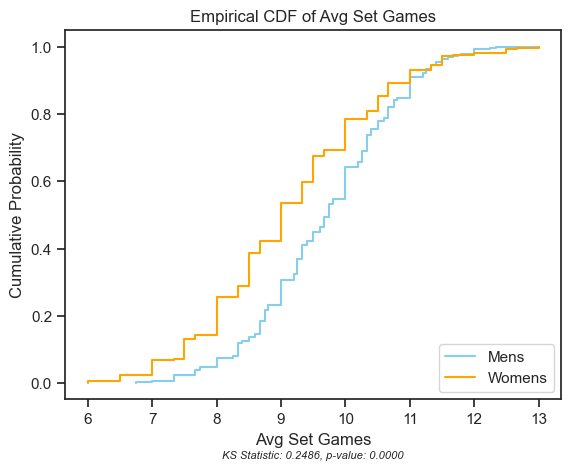

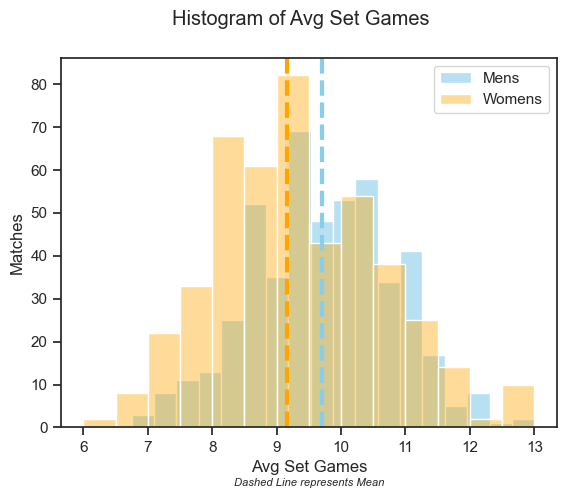

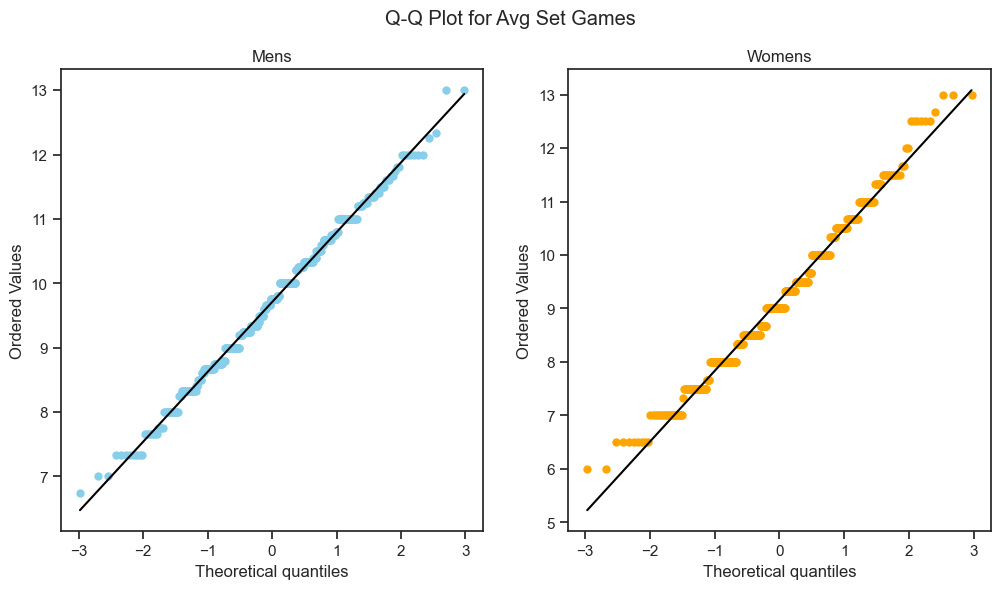

Summary Statistics for Avg Set Length:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 44.8134   | 43.6735   |
+-------------+-----------+-----------+
| Median      | 44.3      | 42.9292   |
+-------------+-----------+-----------+
| Variance    | 55.7151   | 97.3383   |
+-------------+-----------+-----------+
| Skewness    |  0.258821 |  0.620146 |
+-------------+-----------+-----------+
| Kurtosis    |  0.110722 |  0.440302 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.159797 | 9.67076e-06 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      2.00843  | 0.044882    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 123925 

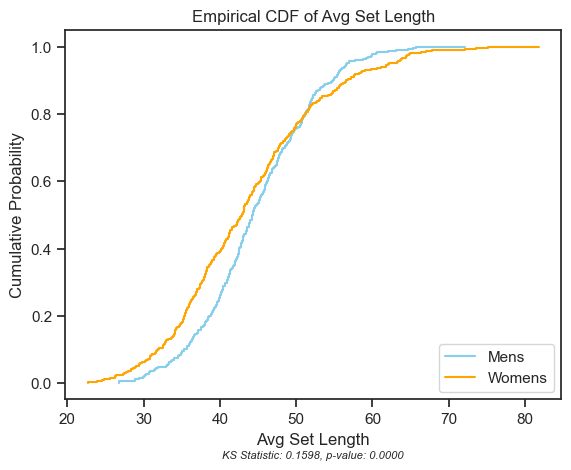

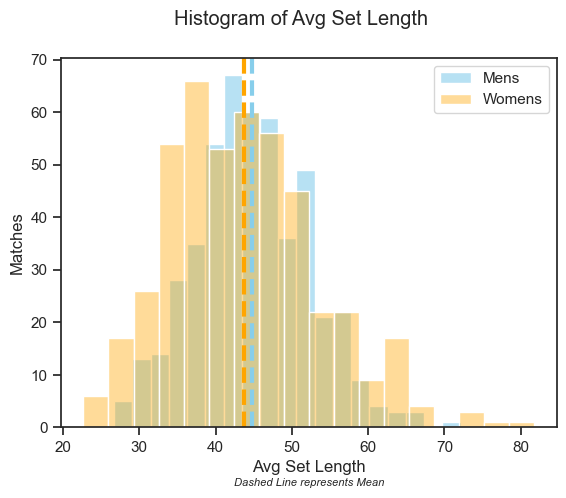

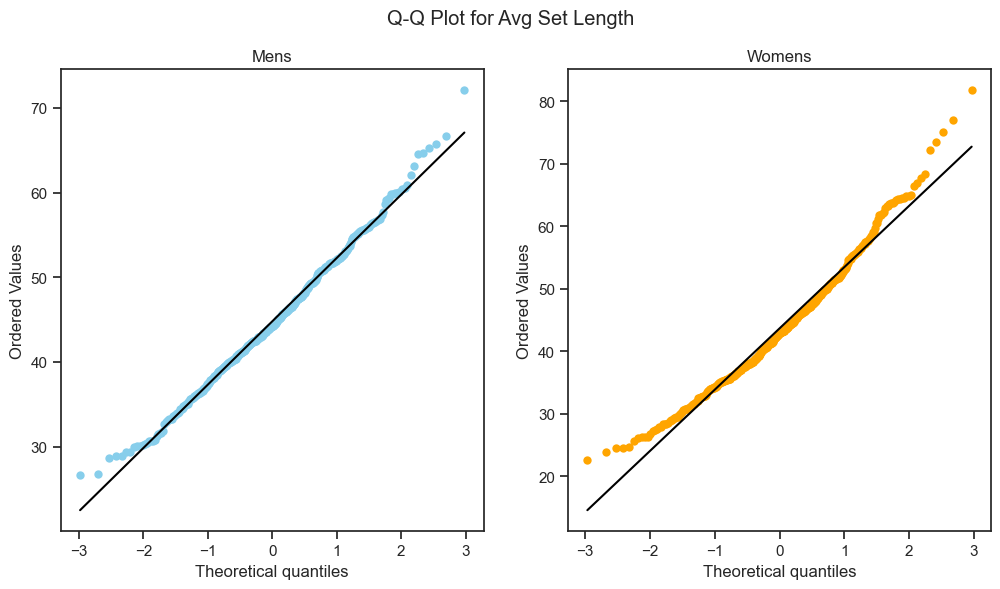

Summary Statistics for Breakpoints Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.42029  |  0.502165 |
+-------------+-----------+-----------+
| Median      |  0.5      |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  0.940467 |  1.72788  |
+-------------+-----------+-----------+
| Skewness    | -0.316314 | -0.303192 |
+-------------+-----------+-----------+
| Kurtosis    | -0.431569 | -0.853303 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.207228 | 2.28448e-09 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -1.09283  | 0.274747    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 1

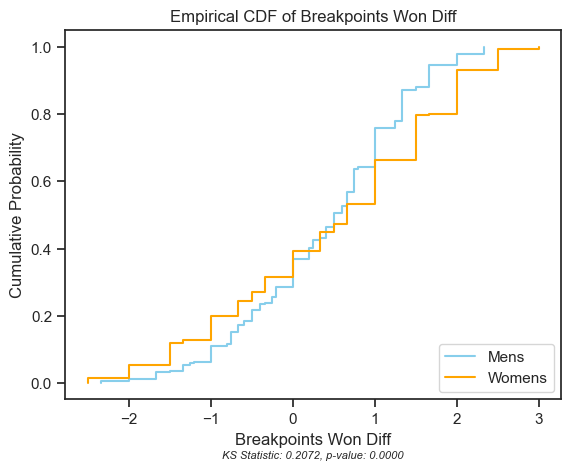

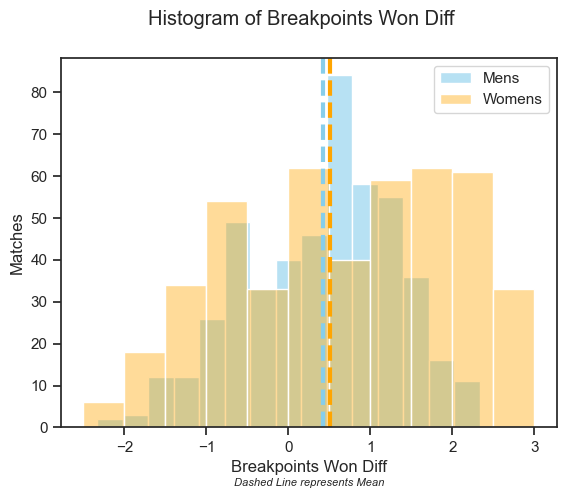

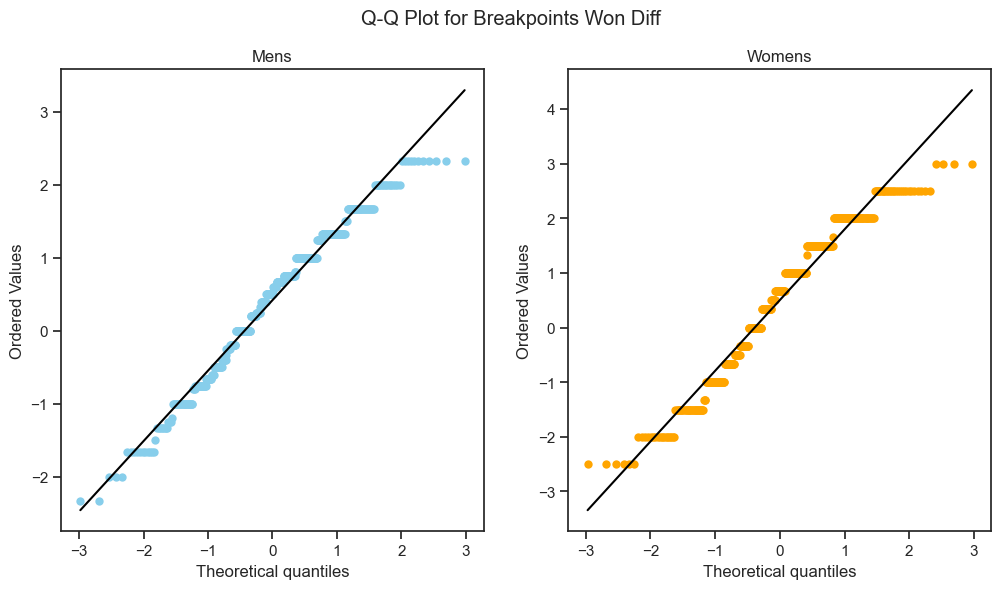

Summary Statistics for Double Faults Diff:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | -0.143202 | 0.00721501 |
+-------------+-----------+------------+
| Median      | -0.2      | 0          |
+-------------+-----------+------------+
| Variance    |  1.04865  | 1.95693    |
+-------------+-----------+------------+
| Skewness    |  0.284552 | 0.122124   |
+-------------+-----------+------------+
| Kurtosis    |  1.18796  | 0.457697   |
+-------------+-----------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.140787 | 0.000148764 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -1.89188  | 0.0588132   |
+-------------------------+---------------+-------------+
| Mann-Whitney U  

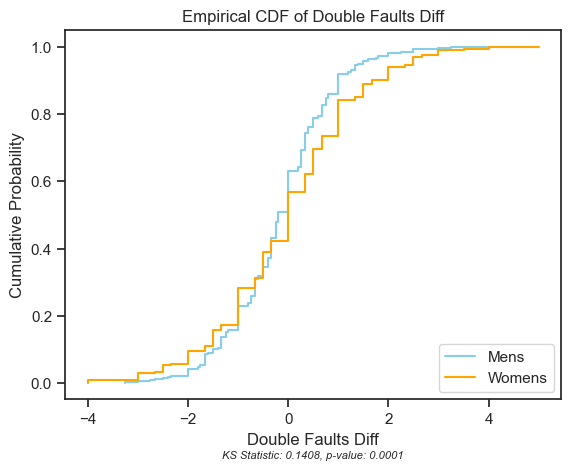

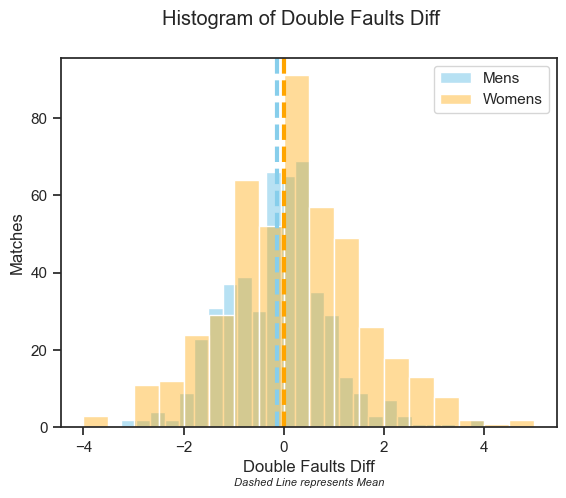

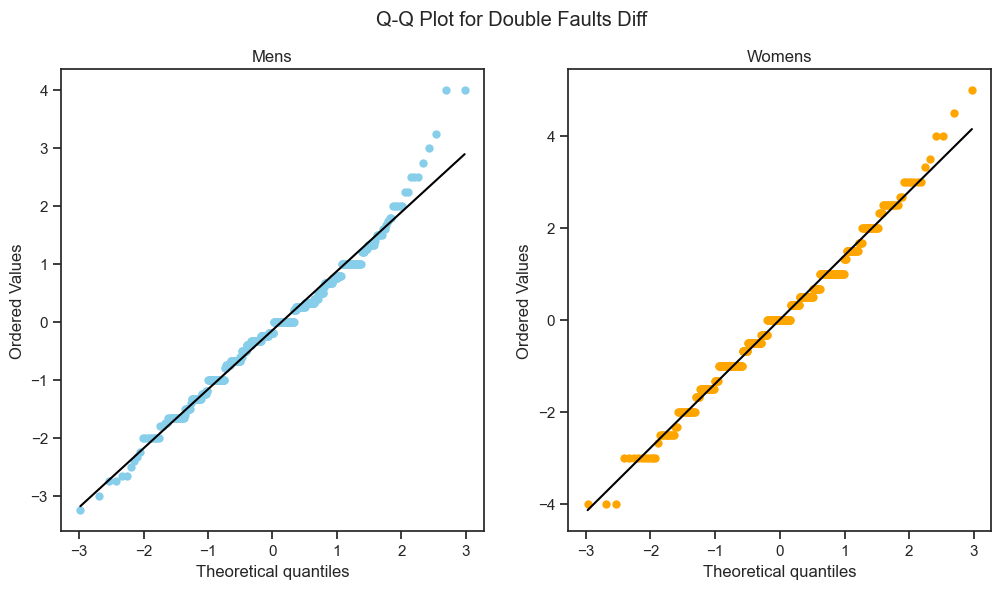

Summary Statistics for Errors Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        | -1.59013   | -1.99603  |
+-------------+------------+-----------+
| Median      | -1.5       | -2        |
+-------------+------------+-----------+
| Variance    | 32.8586    | 47.8112   |
+-------------+------------+-----------+
| Skewness    |  0.0349208 |  0.214226 |
+-------------+------------+-----------+
| Kurtosis    | -0.259722  |  0.271822 |
+-------------+------------+-----------+
+-------------------------+----------------+------------+
| Test                    |      Statistic |    P-value |
+=========================+================+============+
| KS-test (Distribution)  |      0.0676642 | 0.216645   |
+-------------------------+----------------+------------+
| T-test (Means)          |      0.984138  | 0.3253     |
+-------------------------+----------------+------------+
| Mann-Whitney U         

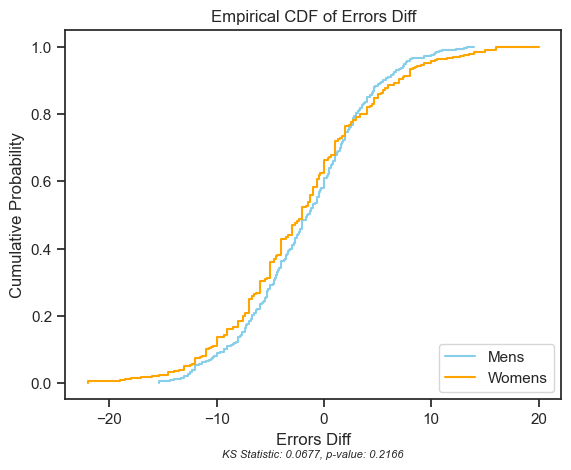

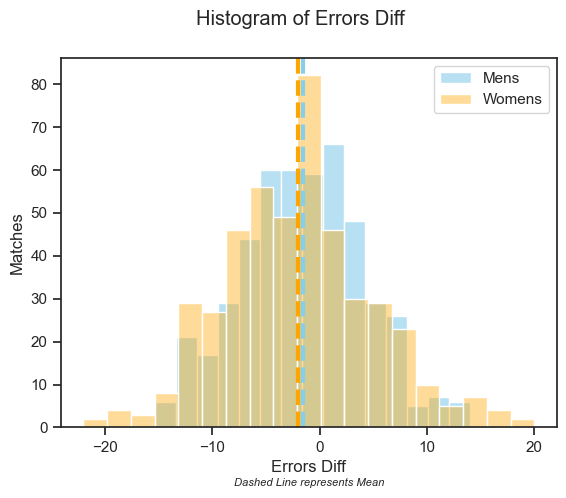

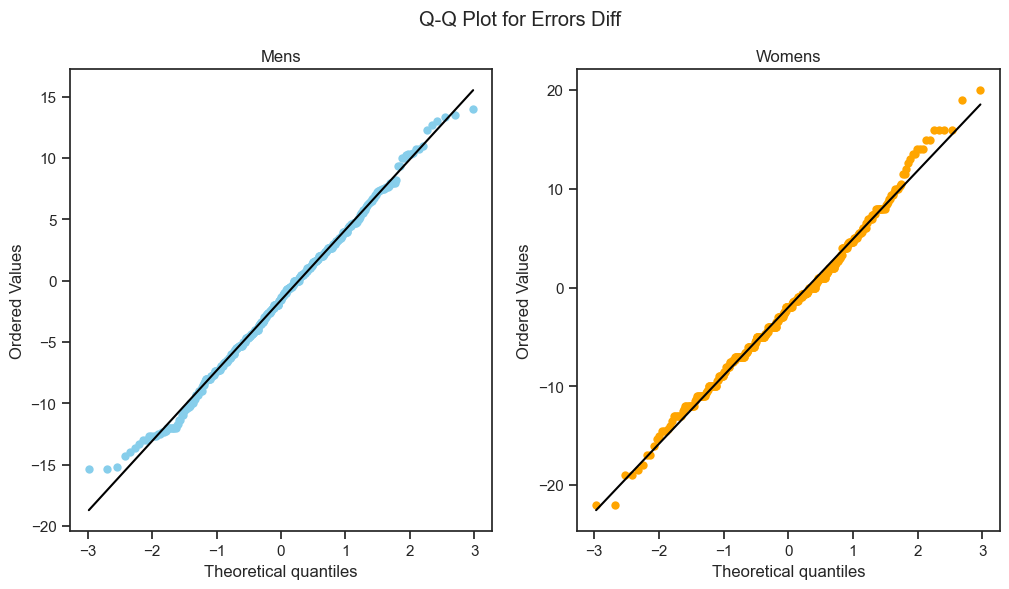

Summary Statistics for First Serve Points Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.569876 |  0.715368 |
+-------------+-----------+-----------+
| Median      |  0.666667 |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  8.26192  | 14.861    |
+-------------+-----------+-----------+
| Skewness    | -0.121017 | -0.239936 |
+-------------+-----------+-----------+
| Kurtosis    |  0.137891 |  0.281001 |
+-------------+-----------+-----------+
+-------------------------+---------------+------------+
| Test                    |     Statistic |    P-value |
+=========================+===============+============+
| KS-test (Distribution)  |      0.119048 | 0.00221203 |
+-------------------------+---------------+------------+
| T-test (Means)          |     -0.659624 | 0.509656   |
+-------------------------+---------------+------------+
| Mann-Whitney U          | 1

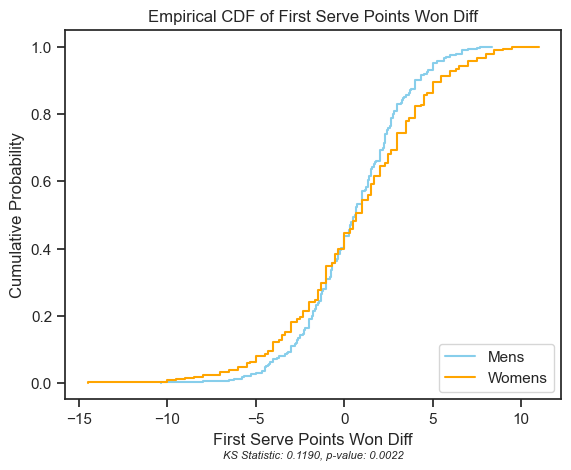

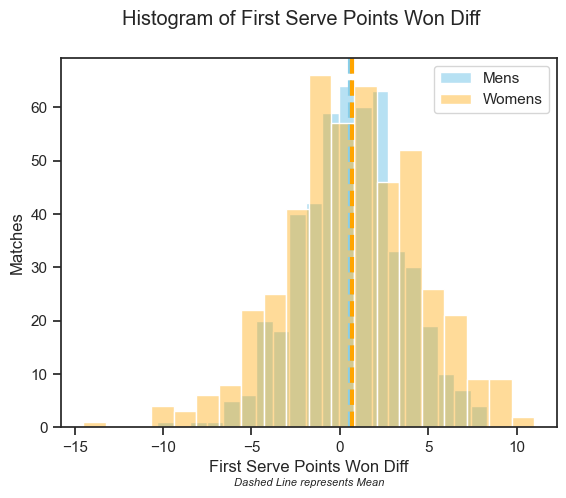

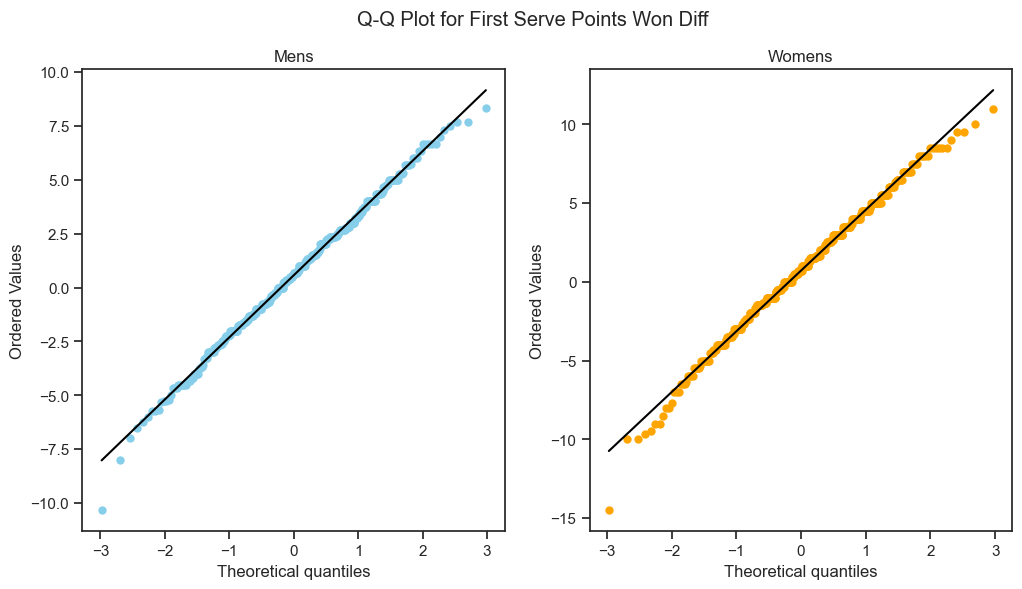

Summary Statistics for First Serve Successful Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        | -0.527778  | -0.593074 |
+-------------+------------+-----------+
| Median      | -0.666667  | -0.5      |
+-------------+------------+-----------+
| Variance    | 15.6873    | 24.3071   |
+-------------+------------+-----------+
| Skewness    | -0.0325827 | -0.160766 |
+-------------+------------+-----------+
| Kurtosis    |  0.273808  |  0.916937 |
+-------------+------------+-----------+
+-------------------------+----------------+-------------+
| Test                    |      Statistic |     P-value |
+=========================+================+=============+
| KS-test (Distribution)  |      0.0638999 | 0.274304    |
+-------------------------+----------------+-------------+
| T-test (Means)          |      0.224918  | 0.822092    |
+-------------------------+----------------+-------------+
| 

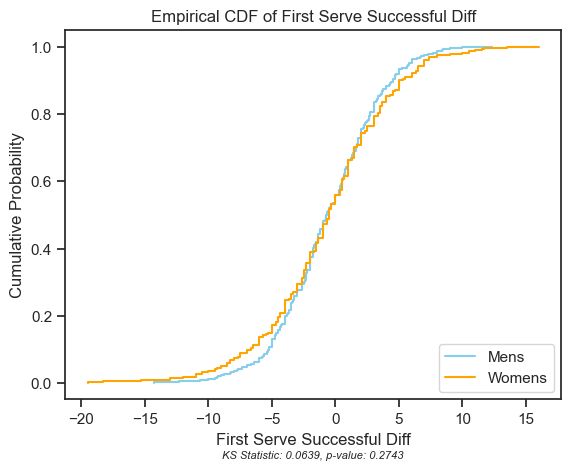

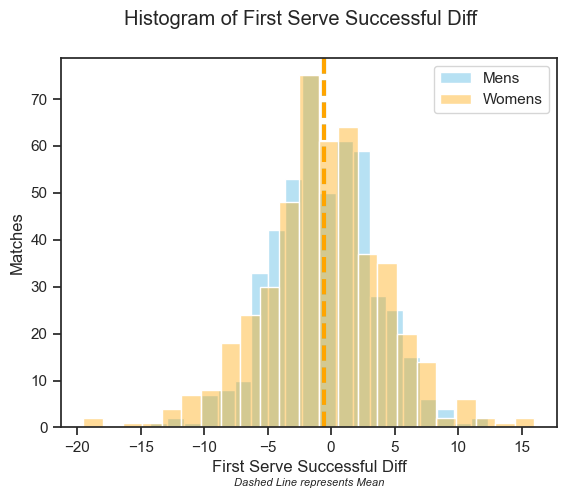

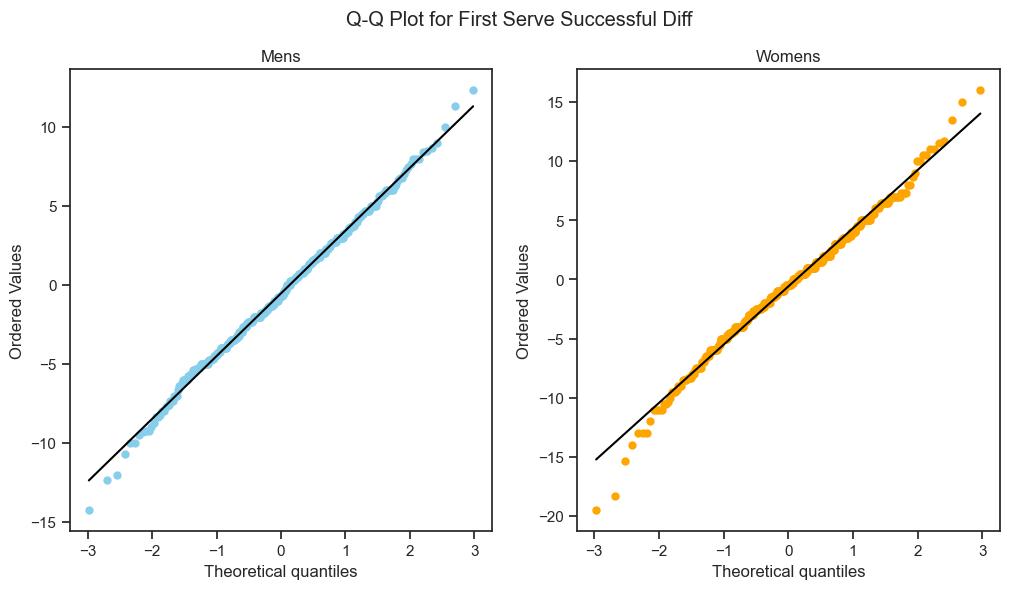

Summary Statistics for Games Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.88989  |  1.00144  |
+-------------+-----------+-----------+
| Median      |  1.25     |  1.33333  |
+-------------+-----------+-----------+
| Variance    |  4.2063   |  7.17161  |
+-------------+-----------+-----------+
| Skewness    | -0.37052  | -0.345768 |
+-------------+-----------+-----------+
| Kurtosis    | -0.604935 | -0.943934 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.157632 | 1.34359e-05 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -0.720791 | 0.471217    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 105237 

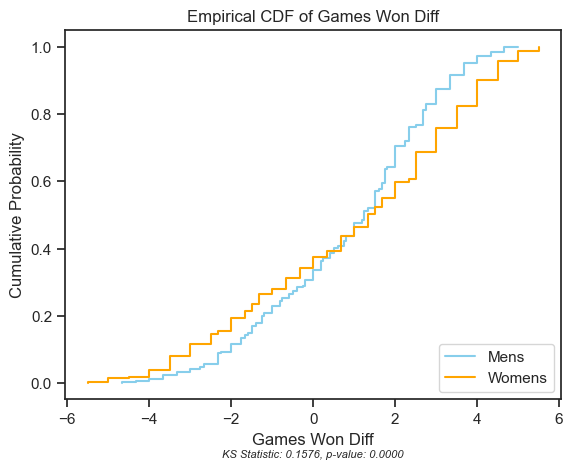

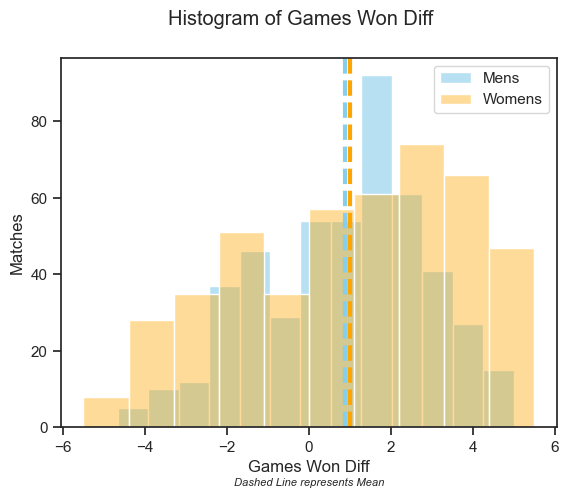

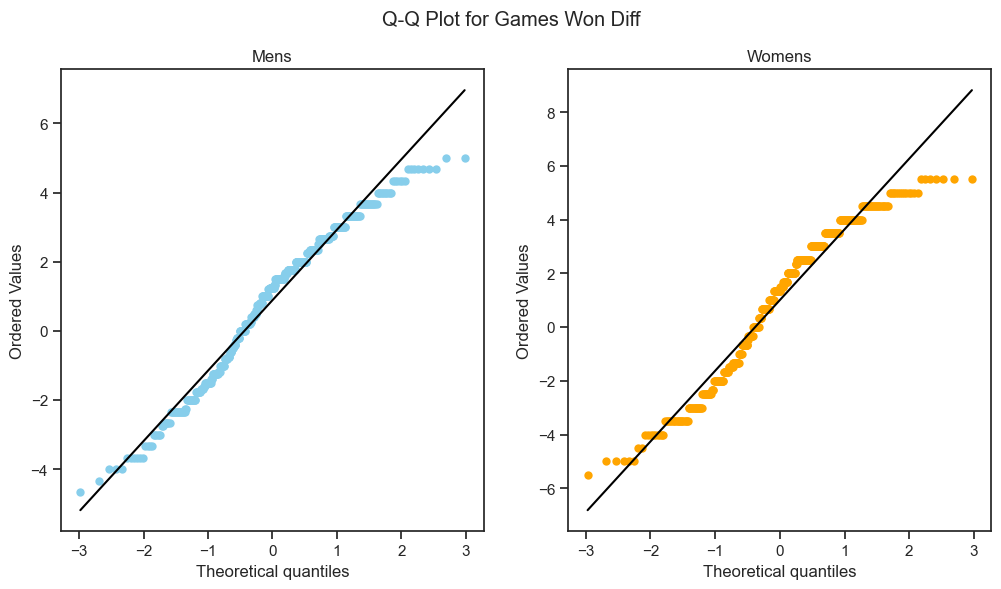

Summary Statistics for Max Games In A Row Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  1.09731   |  1.01515  |
+-------------+------------+-----------+
| Median      |  1         |  1        |
+-------------+------------+-----------+
| Variance    |  8.00088   |  9.71994  |
+-------------+------------+-----------+
| Skewness    | -0.0863761 | -0.063539 |
+-------------+------------+-----------+
| Kurtosis    |  0.831394  |  0.247247 |
+-------------+------------+-----------+
+-------------------------+----------------+-----------+
| Test                    |      Statistic |   P-value |
+=========================+================+===========+
| KS-test (Distribution)  |      0.0447017 | 0.709823  |
+-------------------------+----------------+-----------+
| T-test (Means)          |      0.424586  | 0.671235  |
+-------------------------+----------------+-----------+
| Mann-Whitney U    

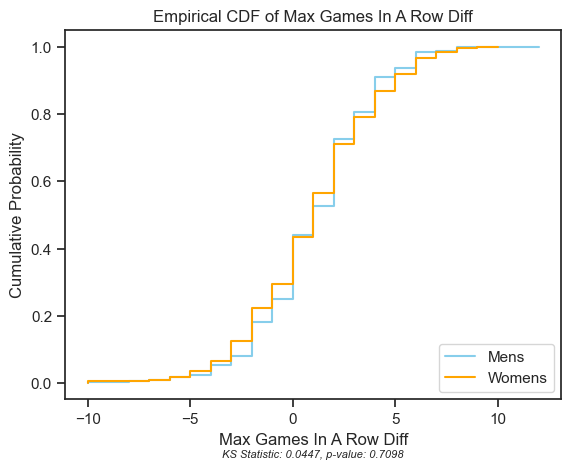

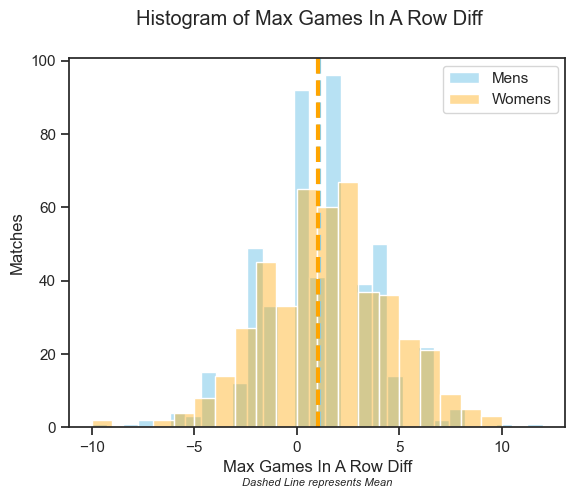

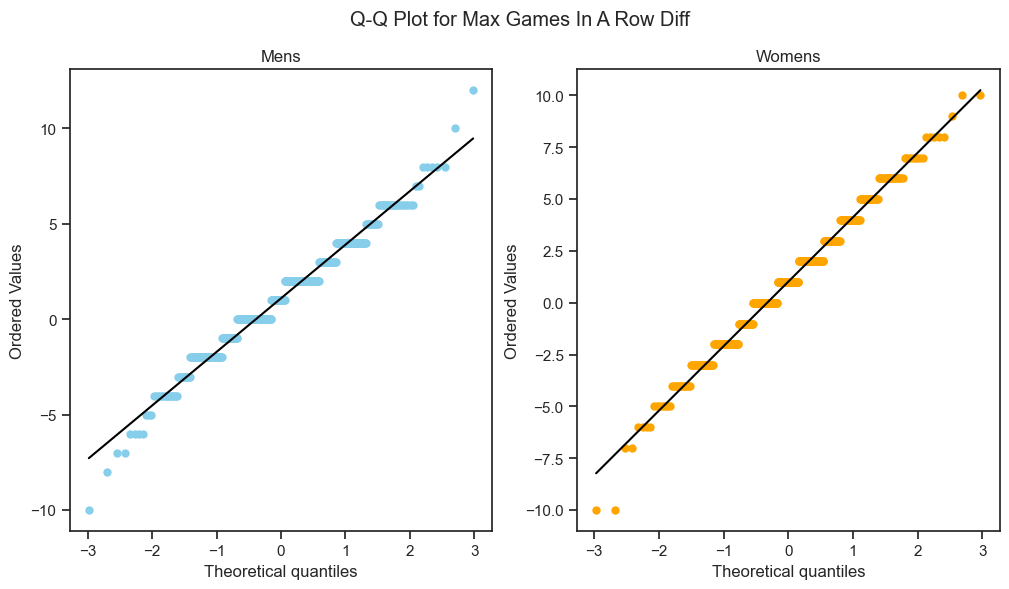

Summary Statistics for Max Points In A Row Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 1.09317   |  0.917749 |
+-------------+-----------+-----------+
| Median      | 1         |  1        |
+-------------+-----------+-----------+
| Variance    | 9.09296   | 10.6266   |
+-------------+-----------+-----------+
| Skewness    | 0.0751073 |  0.166313 |
+-------------+-----------+-----------+
| Kurtosis    | 1.29179   |  1.04306  |
+-------------+-----------+-----------+
+-------------------------+----------------+-----------+
| Test                    |      Statistic |   P-value |
+=========================+================+===========+
| KS-test (Distribution)  |      0.0656879 |  0.245655 |
+-------------------------+----------------+-----------+
| T-test (Means)          |      0.859206  |  0.390445 |
+-------------------------+----------------+-----------+
| Mann-Whitney U          | 1147

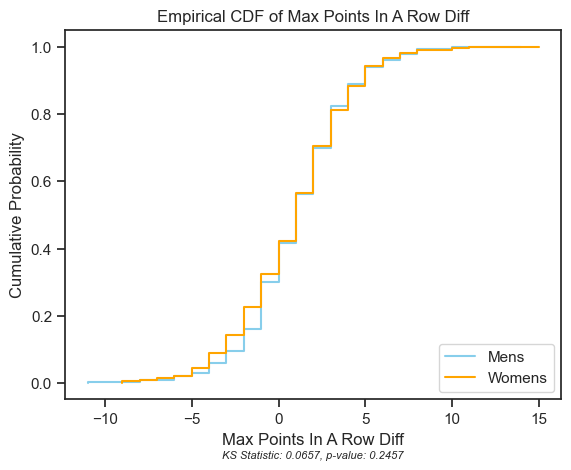

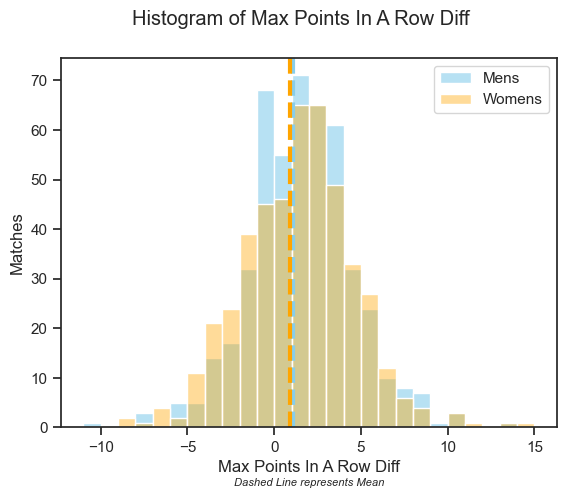

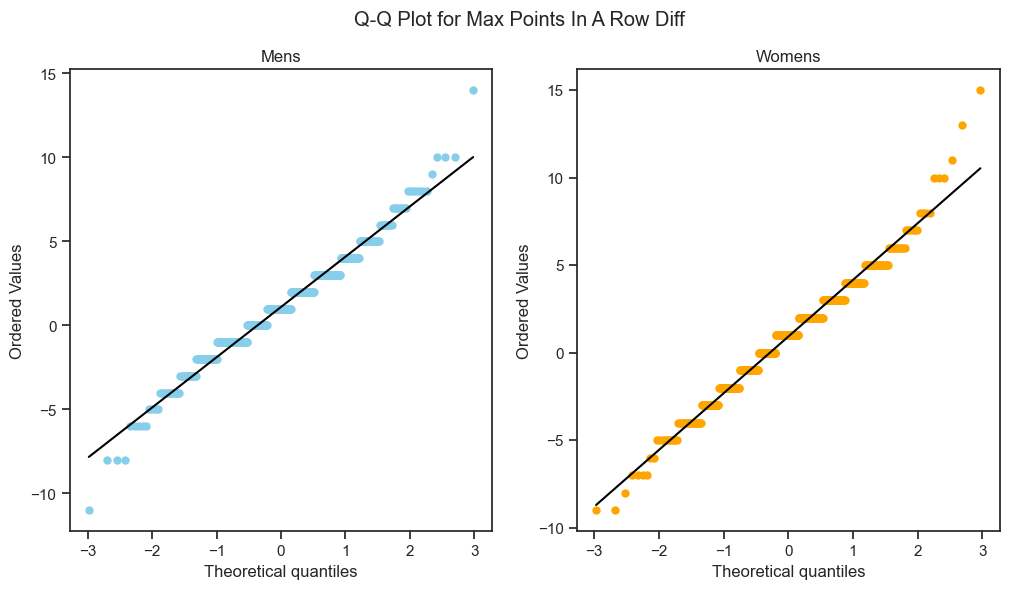

Summary Statistics for Points Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  2.66888  |  2.91342  |
+-------------+-----------+-----------+
| Median      |  3.6      |  4.33333  |
+-------------+-----------+-----------+
| Variance    | 34.4103   | 54.086    |
+-------------+-----------+-----------+
| Skewness    | -0.387892 | -0.348112 |
+-------------+-----------+-----------+
| Kurtosis    | -0.635659 | -0.87669  |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.135328 | 0.000305753 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -0.566327 | 0.571306    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 106106

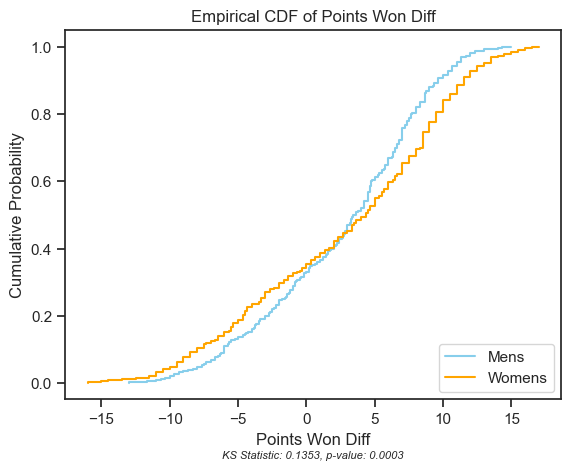

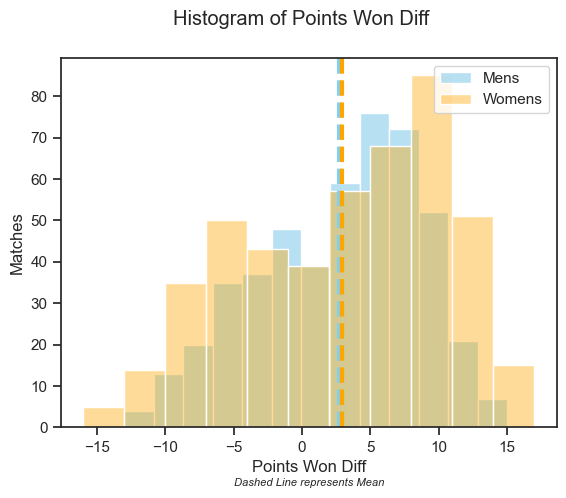

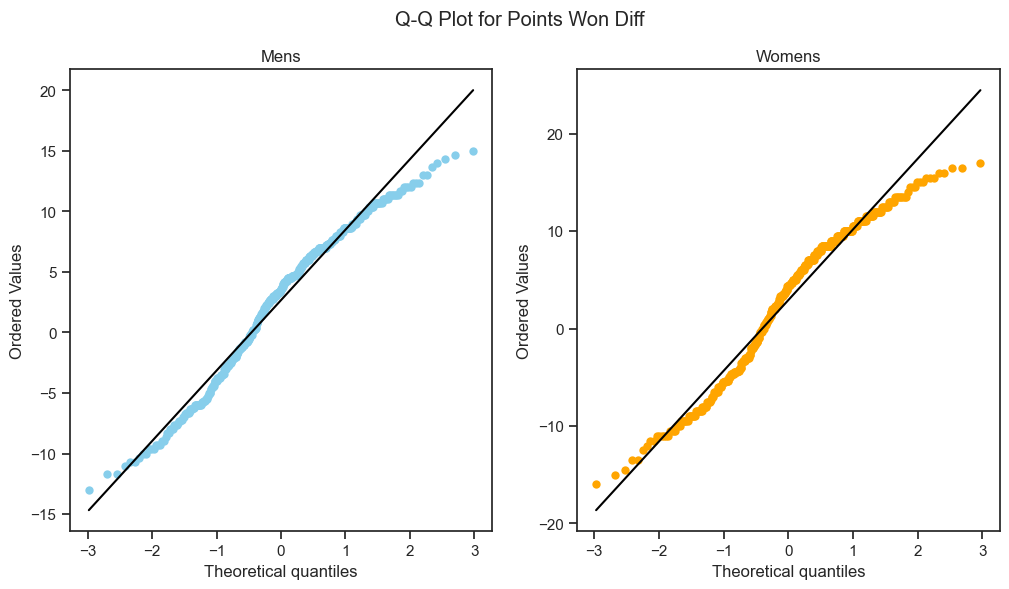

Summary Statistics for Points Won From Last 10 Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.29579  |  0.458874 |
+-------------+-----------+-----------+
| Median      |  0.4      |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  1.14979  |  3.31127  |
+-------------+-----------+-----------+
| Skewness    | -0.330201 | -0.194711 |
+-------------+-----------+-----------+
| Kurtosis    | -0.178408 | -0.304876 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.232731 | 1.02704e-11 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -1.68711  | 0.0919136   |
+-------------------------+---------------+-------------+
| Mann-Whitney U     

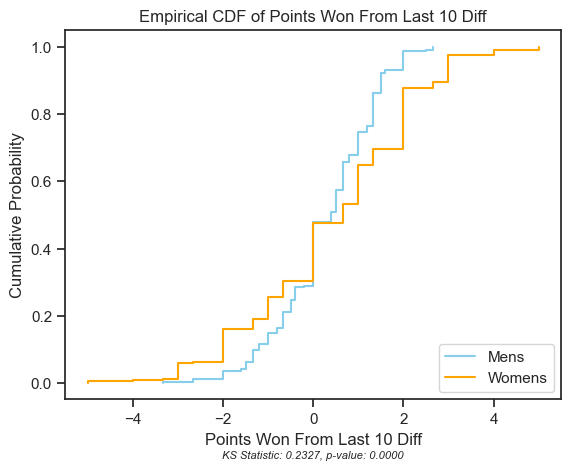

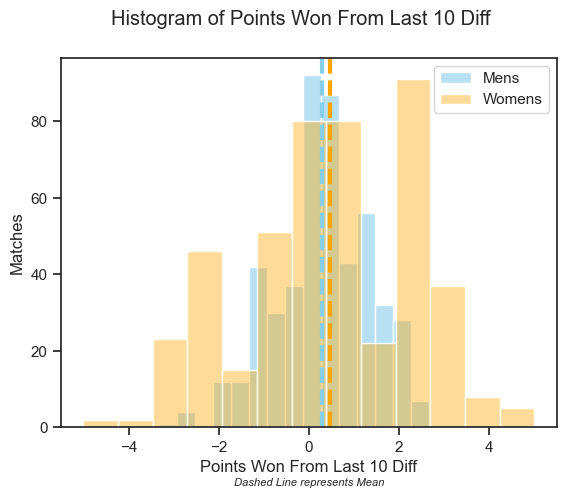

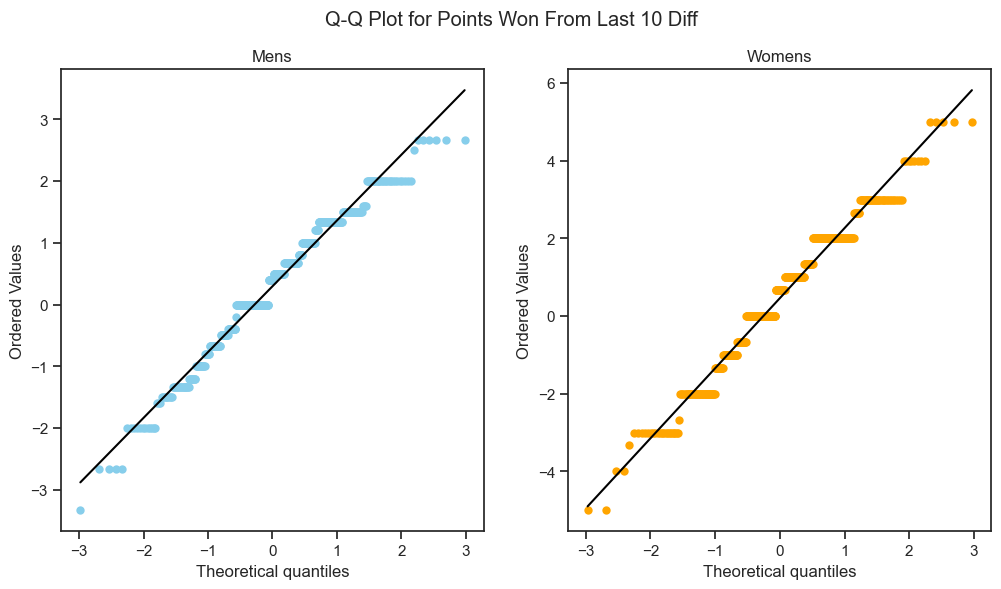

Summary Statistics for Second Serve Points Won Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  0.147101  |  0.473304 |
+-------------+------------+-----------+
| Median      |  0         |  0.5      |
+-------------+------------+-----------+
| Variance    |  3.75195   |  5.4976   |
+-------------+------------+-----------+
| Skewness    |  0.0656925 | -0.208555 |
+-------------+------------+-----------+
| Kurtosis    | -0.215139  | -0.045393 |
+-------------+------------+-----------+
+-------------------------+---------------+------------+
| Test                    |     Statistic |    P-value |
+=========================+===============+============+
| KS-test (Distribution)  |      0.100696 | 0.0151851  |
+-------------------------+---------------+------------+
| T-test (Means)          |     -2.3358   | 0.0197104  |
+-------------------------+---------------+------------+
| Mann-Whitney 

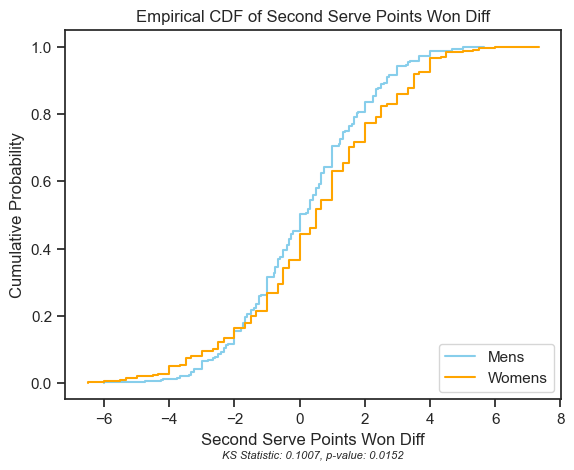

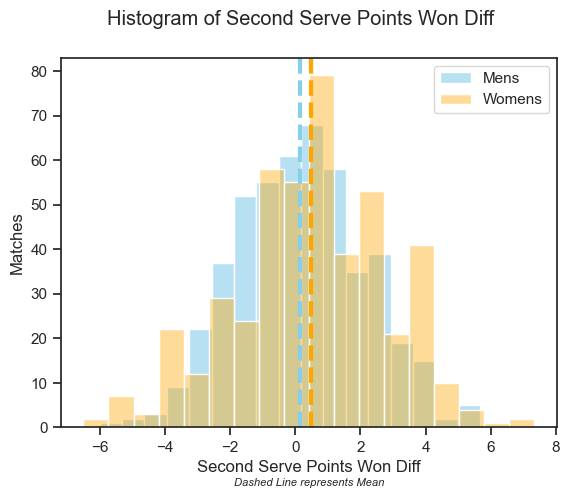

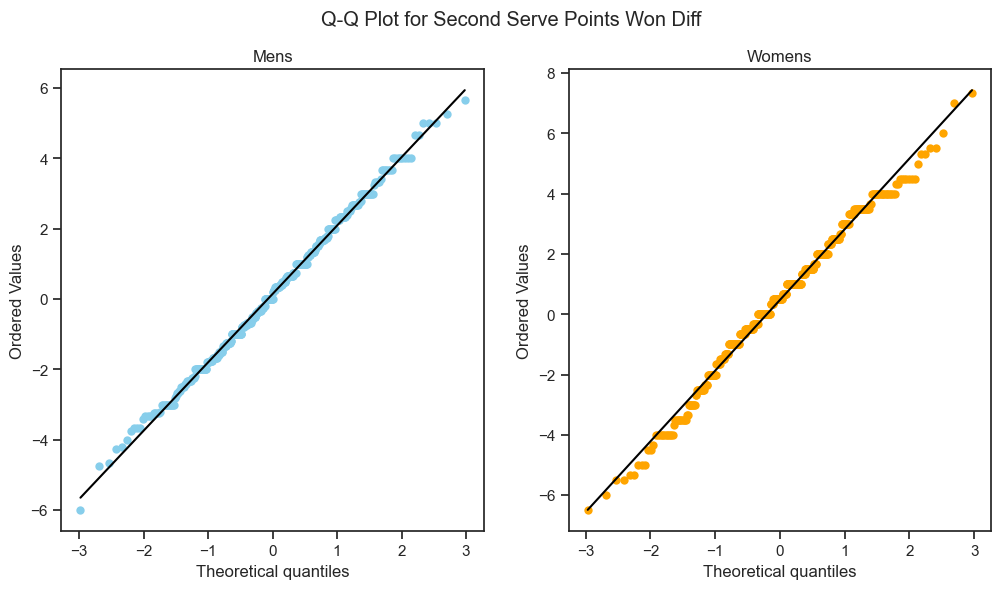

Summary Statistics for Second Serve Successful Diff:
+-------------+-------------+-----------+
| Statistic   |         Men |     Women |
+=============+=============+===========+
| Mean        | -0.543237   |  0.130952 |
+-------------+-------------+-----------+
| Median      | -0.5        |  0        |
+-------------+-------------+-----------+
| Variance    |  7.63384    | 12.6739   |
+-------------+-------------+-----------+
| Skewness    | -0.00152517 | -0.132346 |
+-------------+-------------+-----------+
| Kurtosis    | -0.406001   |  0.52395  |
+-------------+-------------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.118859 | 0.00225986  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -3.26023  | 0.00115309  |
+-------------------------+--------------+-------------+
| 

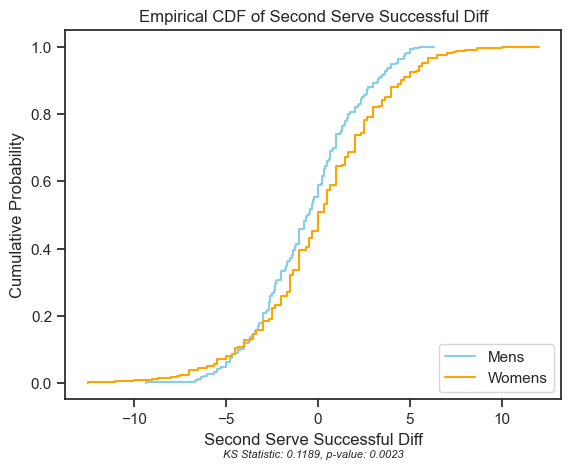

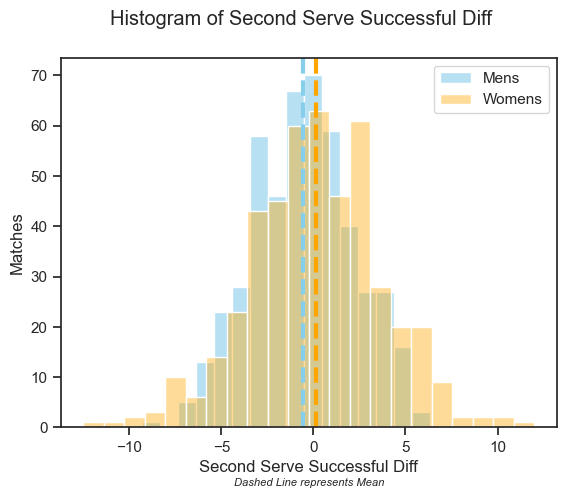

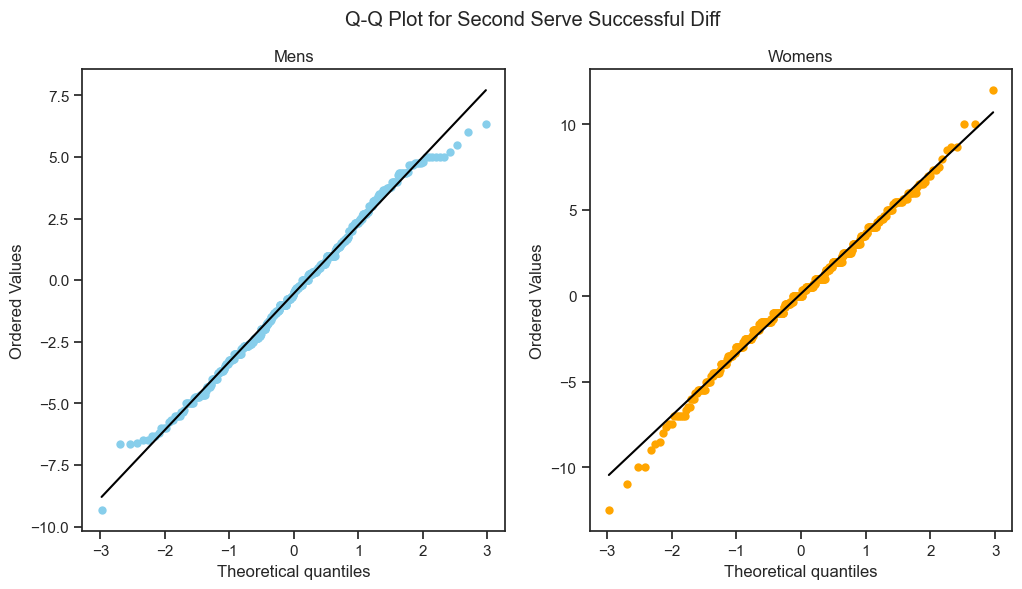

Summary Statistics for Service Games Won Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  0.441822 |  0.520924 |
+-------------+-----------+-----------+
| Median      |  0.666667 |  0.666667 |
+-------------+-----------+-----------+
| Variance    |  1.08832  |  1.88267  |
+-------------+-----------+-----------+
| Skewness    | -0.35509  | -0.330412 |
+-------------+-----------+-----------+
| Kurtosis    | -0.573963 | -0.850185 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.185018 | 1.49904e-07 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -1.00029  | 0.317427    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          |

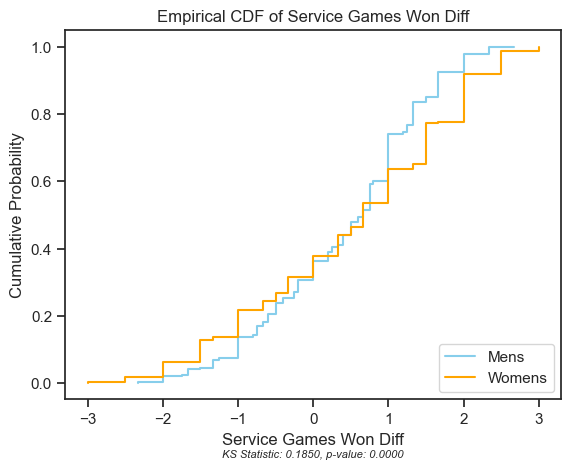

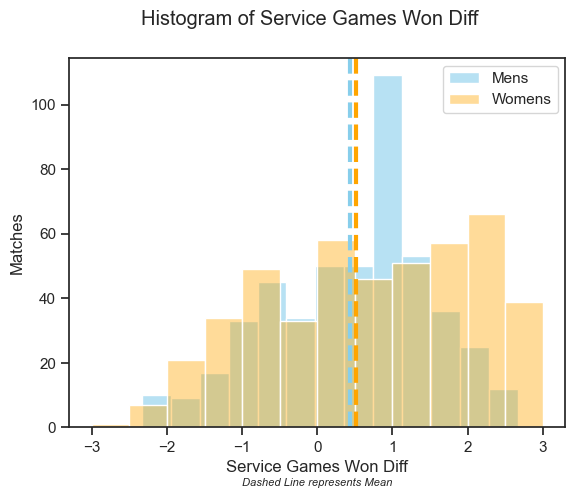

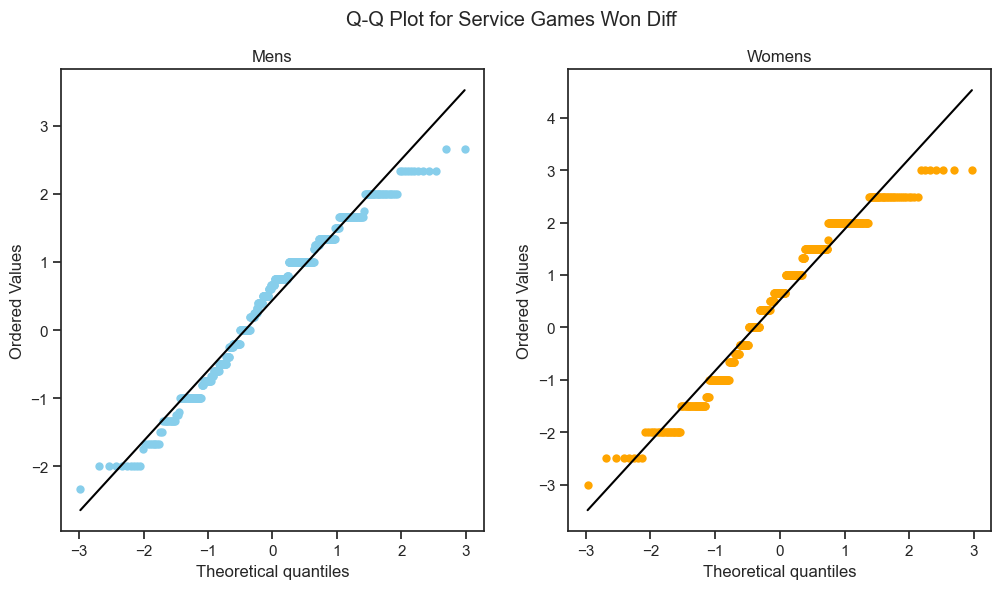

Summary Statistics for Service Points Lost Diff:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | -1.91998  | -1.68434  |
+-------------+-----------+-----------+
| Median      | -2.25     | -1.66667  |
+-------------+-----------+-----------+
| Variance    | 18.7045   | 23.9194   |
+-------------+-----------+-----------+
| Skewness    |  0.266368 |  0.102039 |
+-------------+-----------+-----------+
| Kurtosis    | -0.214365 | -0.51728  |
+-------------+-----------+-----------+
+-------------------------+----------------+------------+
| Test                    |      Statistic |    P-value |
+=========================+================+============+
| KS-test (Distribution)  |      0.0670055 | 0.226011   |
+-------------------------+----------------+------------+
| T-test (Means)          |     -0.785419  | 0.432405   |
+-------------------------+----------------+------------+
| Mann-Whitney U         

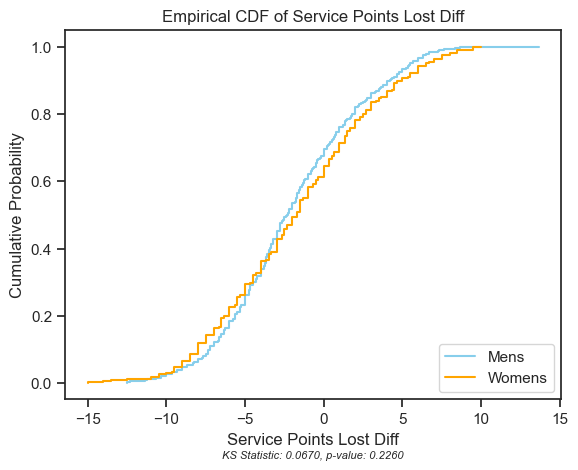

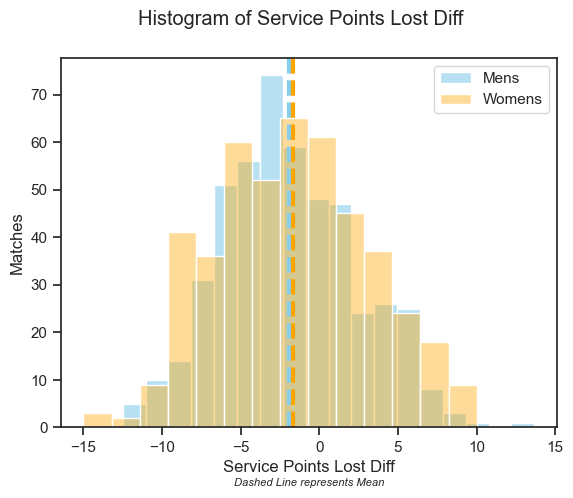

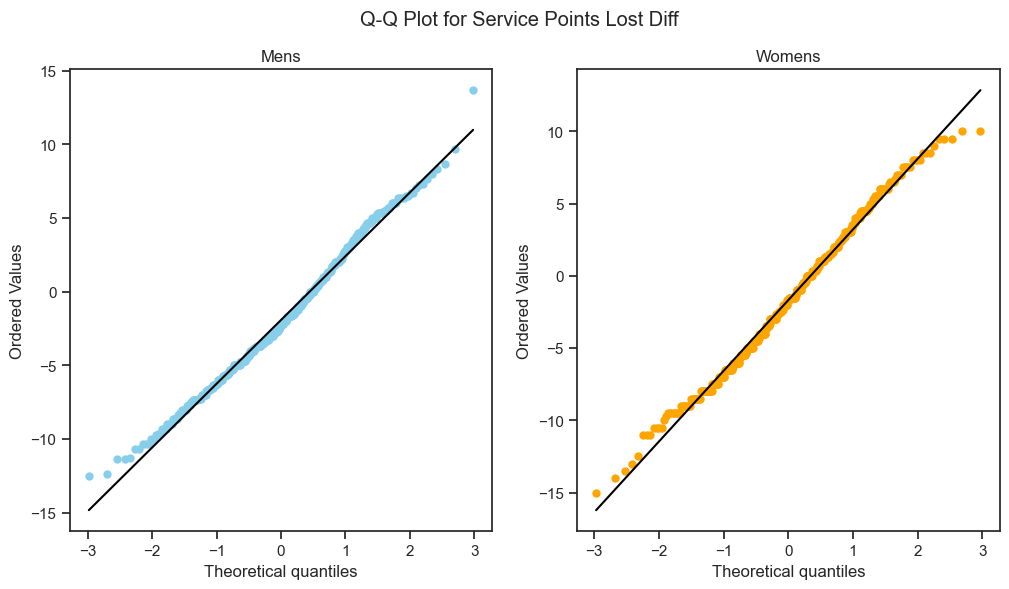

Summary Statistics for Service Points Won Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  0.72305   |  1.193    |
+-------------+------------+-----------+
| Median      |  1         |  1.5      |
+-------------+------------+-----------+
| Variance    |  9.44846   | 20.1653   |
+-------------+------------+-----------+
| Skewness    | -0.0659888 | -0.371957 |
+-------------+------------+-----------+
| Kurtosis    | -0.246126  |  0.436894 |
+-------------+------------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.171372 | 1.54266e-06 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     -1.88433  | 0.059828    |
+-------------------------+---------------+-------------+
| Mann-Whitne

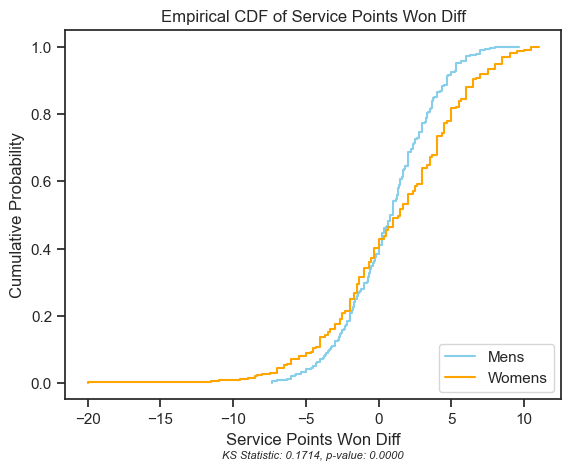

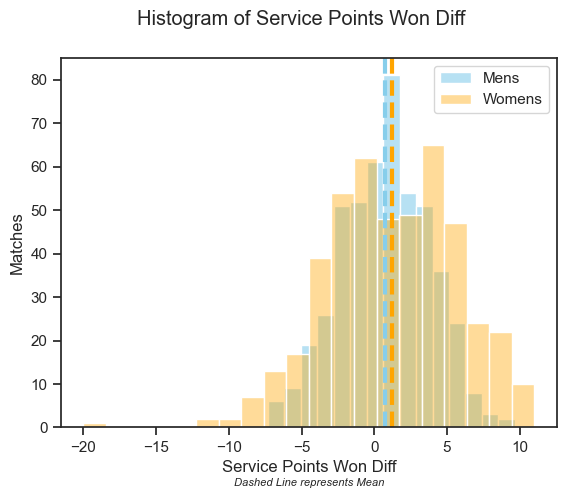

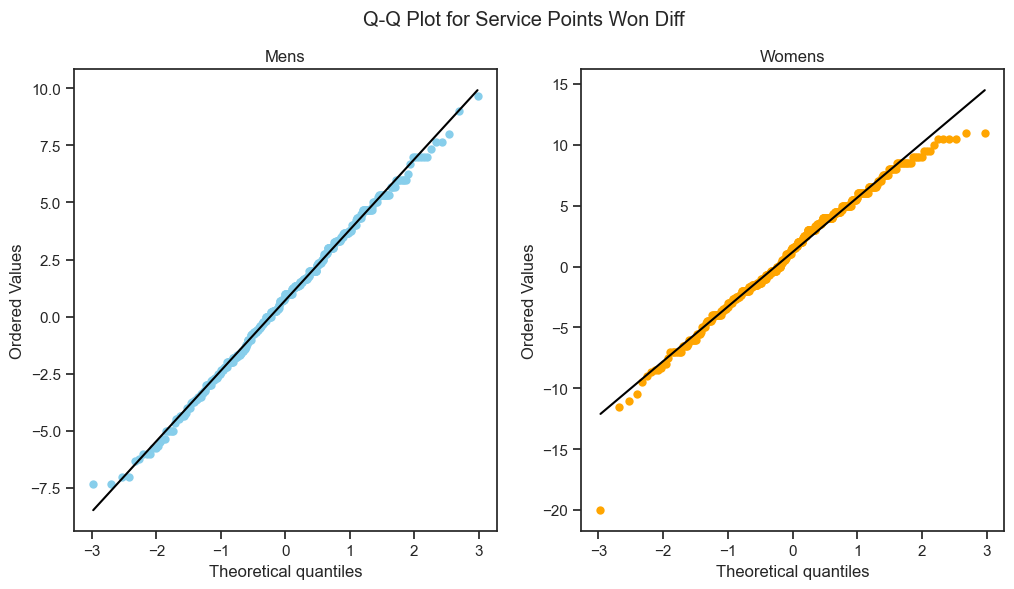

Summary Statistics for Total Breakpoints Diff:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        |  0.860145  |  0.573954  |
+-------------+------------+------------+
| Median      |  0.8       |  0.666667  |
+-------------+------------+------------+
| Variance    |  4.11185   |  5.89841   |
+-------------+------------+------------+
| Skewness    | -0.0250013 | -0.286522  |
+-------------+------------+------------+
| Kurtosis    | -0.179807  |  0.0429042 |
+-------------+------------+------------+
+-------------------------+----------------+-------------+
| Test                    |      Statistic |     P-value |
+=========================+================+=============+
| KS-test (Distribution)  |      0.0849802 | 0.0612408   |
+-------------------------+----------------+-------------+
| T-test (Means)          |      1.96966   | 0.0491694   |
+-------------------------+----------------+---------

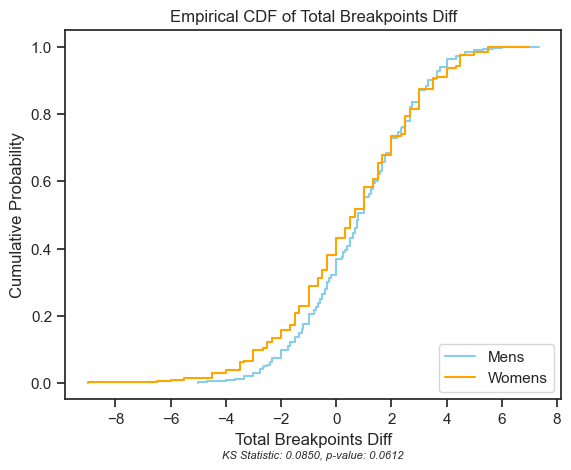

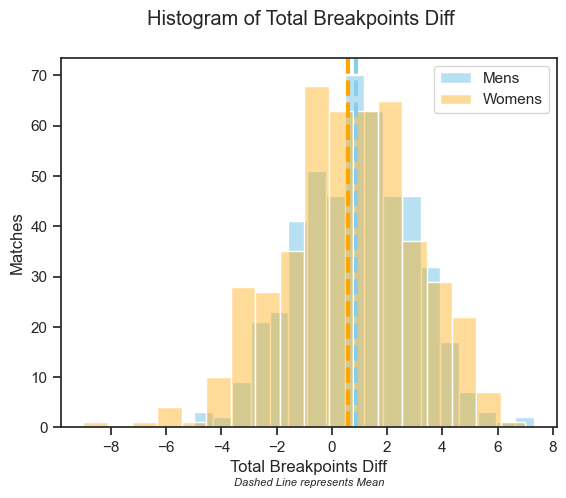

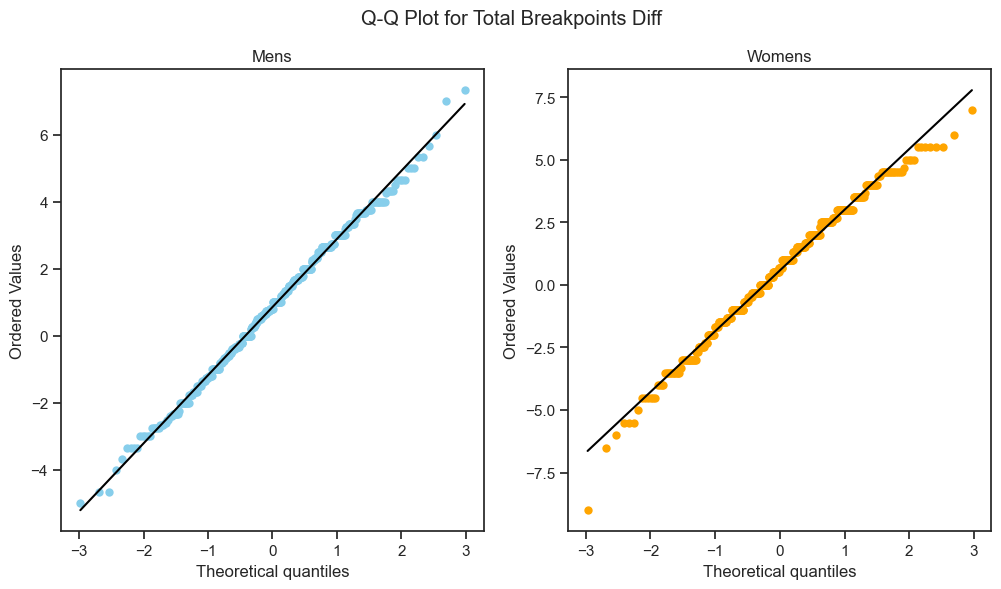

Summary Statistics for Unforced Errors Diff:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        | -1.34838   |   0.600649 |
+-------------+------------+------------+
| Median      | -1.5       |   0.666667 |
+-------------+------------+------------+
| Variance    | 62.5339    | 139.128    |
+-------------+------------+------------+
| Skewness    | -0.0262045 |   0.111864 |
+-------------+------------+------------+
| Kurtosis    | -0.0141267 |  -0.159612 |
+-------------+------------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |      0.14841 | 5.18444e-05 |
+-------------------------+--------------+-------------+
| T-test (Means)          |     -2.99533 | 0.00281319  |
+-------------------------+--------------+-------------+
| Mann-Whi

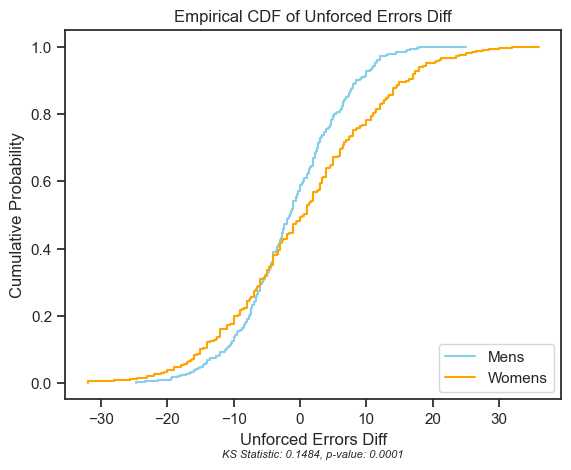

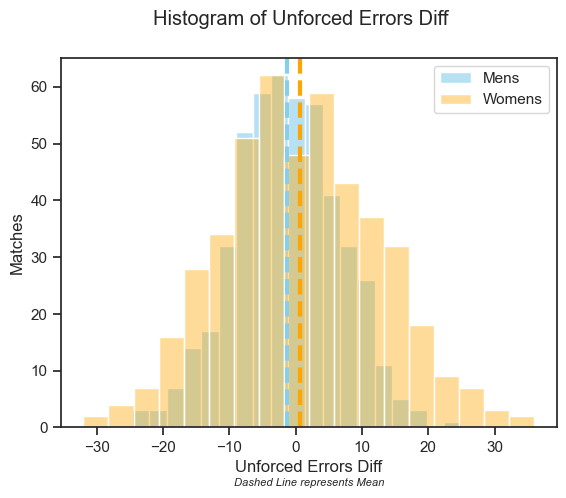

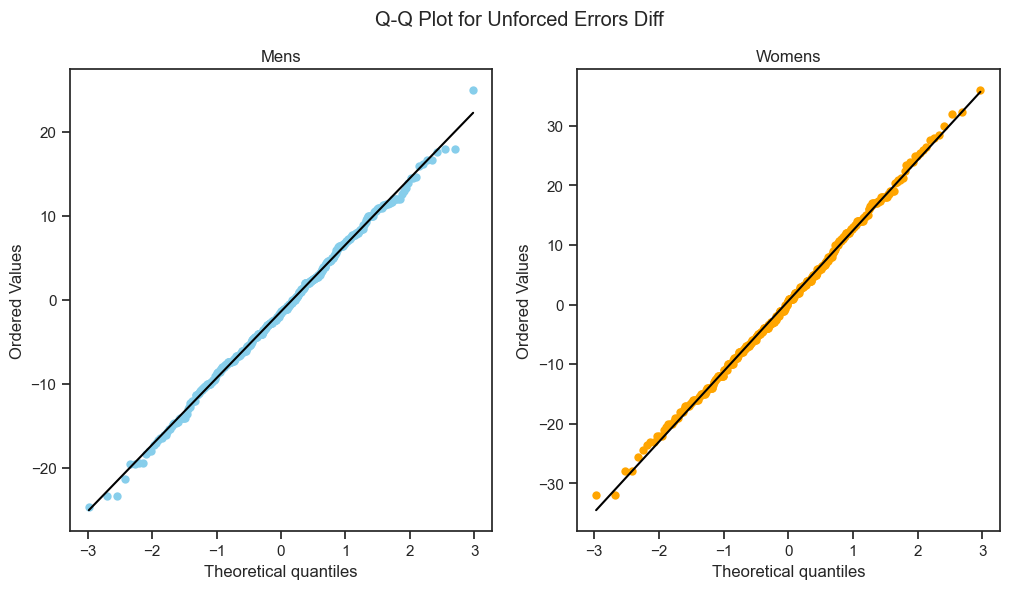

Summary Statistics for Winners Diff:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  1.39396   |  3.47583  |
+-------------+------------+-----------+
| Median      |  1.33333   |  3.5      |
+-------------+------------+-----------+
| Variance    | 52.1145    | 97.7876   |
+-------------+------------+-----------+
| Skewness    |  0.0926633 | -0.105201 |
+-------------+------------+-----------+
| Kurtosis    |  0.130854  |  0.12338  |
+-------------+------------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.193488 | 3.21864e-08 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -3.70784  | 0.000221226 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 947

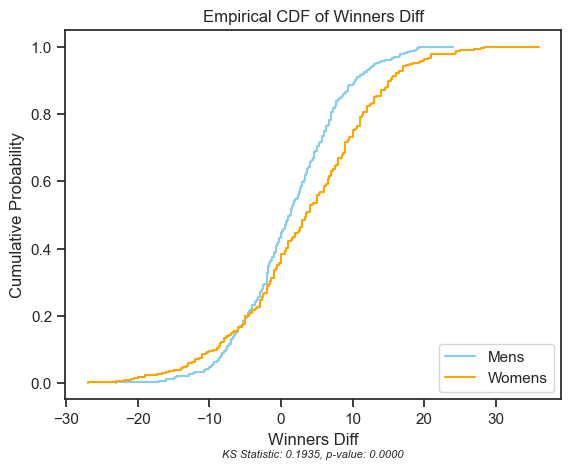

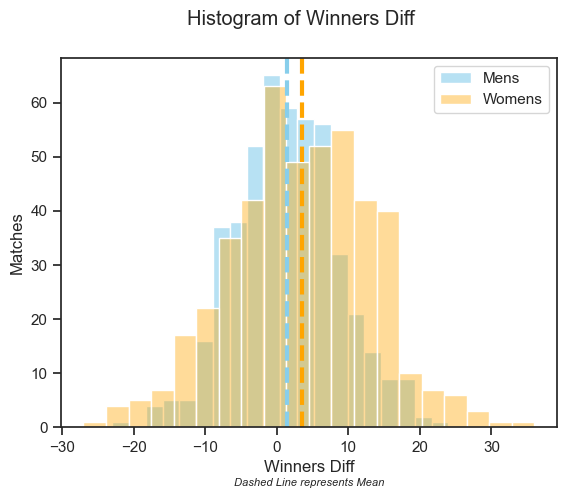

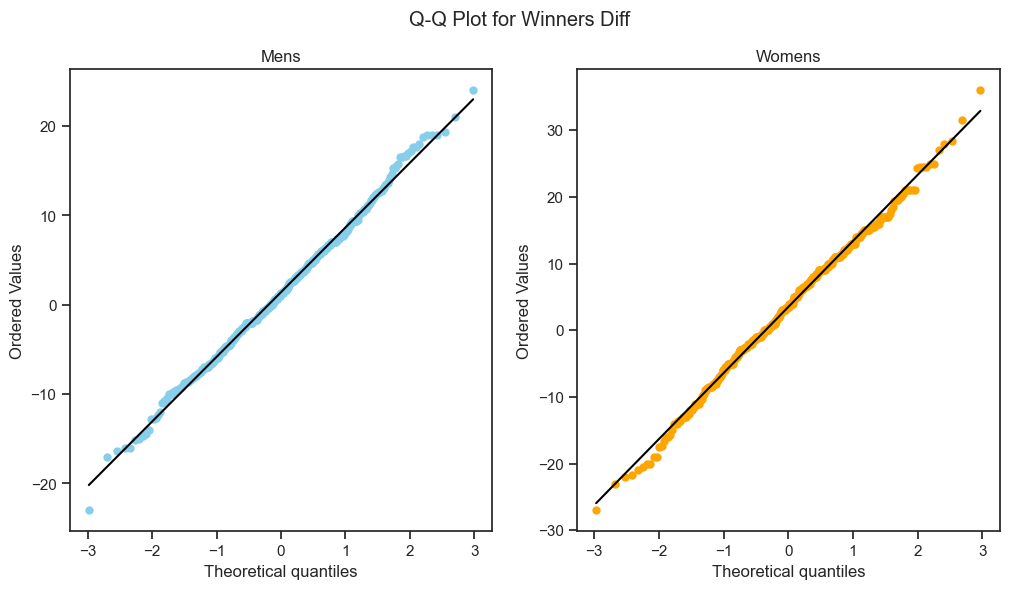

In [63]:
for feature in sorted(features_diff):
    summarize(stats_df,feature)
    plt_ecdf(stats_df, feature)
    plt_dist(stats_df, feature)
    plt_qq(stats_df, feature, "Q-Q Plot for "+feature.replace("_"," ").title())